### This Loop is going to do a few things. Mainly, I am trying to save the Skill Scores of this NAO Model->Temp to look at how well it's performing.

I may tack on some of those bar plots from Mayer and Barnes (2021) here at the end. 

I will have a separate coding file to do LRP. 

In [4]:
%matplotlib inline
##so-called "math" related imports
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

#plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.callbacks import EarlyStopping

tf.compat.v1.disable_eager_execution()
import innvestigate

In [5]:
#import definitions from skill stat file
from SkillStats_MOD import BSS
from SkillStats_MOD import RAS_two
from SkillStats_MOD import PAS_two
from climoprobs import climo

import random
import sklearn

In [6]:
#inputs ... CHANGE FOR WHATEVER REGION YOU WANT TO LOOK AT 
infile = open("../data/1203_g.p", 'rb') 
input = pickle.load(infile)
infile.close()

infile = open("../data/1203_classmedian_t.p", 'rb')
temp = pickle.load(infile)
infile.close()


#infile = open("../data/ANN/eur_climoprob_filt.p", 'rb')
#climo = pickle.load(infile)
#infile.close()

In [7]:
##checking shapes
print(input.shape)
print(temp.shape)

(63, 151, 21, 37)
(63, 151)


In [8]:
temp = temp.reshape(63,151)

In [9]:
##introduce tw-day time lag
temp_n = np.zeros((63,145))
input_n = np.zeros((63,145,21,37))

for i in range(63):
    for j in range(6,145):
        temp_n[i,j-6] = temp[i,j+6]
        input_n[i,j-6] = input[i,j,:,:]     

In [10]:
##Set X_all and Y_all datasets
X_all = np.copy(input_n.reshape(63*145,777))
Y_all = np.copy(temp_n.reshape(63*145))

##training data partition out
X_tri = X_all[:59*145,:]
Y_tri = Y_all[:59*145]

#testing data partition out
X_tes = X_all[59*145:,:]
Y_tes = Y_all[59*145:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [11]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin setting up parts of my model architecture.

The first few cells here are for partitioning data and setting up lists to save skill scores. 

In [12]:
##set fraction of data as 6 years
frac_ind = 147*6
frac_ind

882

In [13]:
##number of input nodes, (lat*lon)
numb_int = X_all.shape[-1]

In [14]:
##Loss and ACC lists, only relevant w/o early stopping
train_loss = []
val_loss = []
cat_acc = []
val_acc = []

In [15]:
##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((100,2))
BSS_val= np.empty((100,2))
BSS_train= np.empty((100,2))
BSS_test= np.empty((100,2))

##RAS and PAS Arrays
Prec_all= np.empty((100,2))
Rec_all= np.empty((100,2))

Prec_val= np.empty((100,2))
Rec_val= np.empty((100,2))

Prec_train= np.empty((100,2))
Rec_train= np.empty((100,2))

Prec_test= np.empty((100,2))
Rec_test= np.empty((100,2))

In [16]:
####for LRP
comp_pos = np.empty((100,777))
comp_neg = np.empty((100,777))
compFpos = np.empty((100,777))
compFneg = np.empty((100,777))

pos90_LRP= np.empty((100,21,37))
neg90_LRP= np.empty((100,21,37))
Fpos90_LRP= np.empty((100,21,37))
Fneg90_LRP= np.empty((100,21,37))

In [17]:
##Testing Accuracy Arrays
fulltest_acc = []
test90_acc = []

##Training Accuracy Arrays
fulltrain_acc = []
train90_acc = []

##Validation Accuracy Arrays
fullval_acc = []
val90_acc = []

### Model architecture specifics start here.

In [18]:
###### batch, epochs, etc
batch_size = 256 #The number of samples the network sees before it backpropagates (batch size)
epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [19]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [20]:
##DEFINITION STATEMENT FOR MODEL ITSELF
def basic_ANN(number_inputs,num_cats,n1,n2,rl1,rl2,learn,epochs):
    ##input tensor has the shape of the number of nodes, 777
    input_tensor = Input(shape=(int(number_inputs),))
    #first dense layer
    layer1 = layers.Dense(n1, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1))(input_tensor)
    #second dense layer
    layer1 = layers.Dense(n2, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl2))(layer1)
    #decay_rate = learn / epochs ###option for decaying learning rate
    #output layer with 2 categories
    output_tensor = layers.Dense(num_cats,activation='softmax')(layer1)
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [21]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [22]:
##Early Stopping Condition, if desired
early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1)

In [23]:
##full dataset climo probabilities 
climo_full = climo(Y_all,63,145)

In [24]:
##create loop for cross validation
for l in range(0,100):
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_tri[:,0])-frac_ind)
    end = start+(frac_ind)

    #choose random 6 year window of training data to be used for validation
    X_val = X_tri[start:end]
    Y_val = Y_tri[start:end]

    #remaining 53 years of training data
    X_train1 = X_tri[0:start]
    Y_train1 = Y_tri[0:start]
    X_train2 = X_tri[end:]
    Y_train2 = Y_tri[end:]

    climo_train1 = climo_full[0:start,:]
    climo_train2 = climo_full[end:59*145,:]

    ##concatenate all of these
    X_tr = np.concatenate((X_train1,X_train2))
    Y_tr = np.concatenate((Y_train1,Y_train2))
    
    climo_train = np.concatenate((climo_train1,climo_train2))
    
    ##calculate class weights on remaining training data
    class_weight = class_weight_creator(Y_tr)

    ##pause, calculate climo probabilities
    climo_val = climo_full[start:end,:]
    climo_test = climo_full[59*145:,:]

    ##initalize model
    #model = basic_ANN(numb_int, 2, 128, 8, 0.08, 0.07, 0.0025, epochs)
    model = basic_ANN(numb_int, 2, 124, 24, 0.77, 0.34, 0.0012, epochs)
    ##FIT the model

    model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val),
              batch_size=batch_size, epochs=epochs, shuffle=shuffle,
              class_weight = class_weight, callbacks=[early_stopping])
    
    train_loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    cat_acc.append(model.history.history['categorical_accuracy'])
    val_acc.append(model.history.history['val_categorical_accuracy'])
     
    pred = model.predict(X_all)
    pred_val = model.predict(X_val)
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_tes)
    ########################################################################################################
    ##STATISTICS CALCULATINNG
    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []
    ##BRIER SKILL SCORE
    BSS(l, start, end,
        climo_full, pred, Y_all, BSS_all,
        climo_val, pred_val, Y_val, BSS_val,
        climo_train, pred_train, Y_tr, BSS_train,
        climo_test, pred_test, Y_tes, BSS_test)
    ##RECALL ACCURACY SCORE    
    RAS_two(l, Rec_all, climo_full, Y_all, pred, pred_class,
            climo_val, Rec_val, Y_val, pred_val, predval_class,
            climo_train, Rec_train, Y_tr, pred_train, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test, predtest_class)
    ##PRECISION ACCURACY SCORE     
    PAS_two(l, Prec_all, climo_full, Y_all, pred, pred_class,
            climo_val, Prec_val, Y_val, pred_val, predval_class,
            climo_train, Prec_train, Y_tr, pred_train, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test, predtest_class)
    ########################################################################################################
    ##ACC
    ##TESTING
    q90 = np.percentile(pred_test,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test90 = pred_test[great90]
    test90_norm = Y_tes[great90]
    test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
    ##full model
    fulltest_acc.append(calculate_accuracy(Y_tes, pred_test, threshold=0.5))

    ##TRAINING
    q90 = np.percentile(pred_train,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_train) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    train90 = pred_train[great90]
    train90_norm = Y_tr[great90]
    train90_acc.append(calculate_accuracy(train90_norm, train90, threshold=0.5))
    ##full model
    fulltrain_acc.append(calculate_accuracy(Y_tr, pred_train, threshold=0.5))

    ##VALIDATION
    q90 = np.percentile(pred_val,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = great90 = [i for i, row in enumerate(pred_val) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    val90 = pred_val[great90]
    val90_norm = Y_val[great90]
    val90_acc.append(calculate_accuracy(val90_norm, val90, threshold=0.5))
    ##full model
    fullval_acc.append(calculate_accuracy(Y_val, pred_val, threshold=0.5))

    
    ########################################################################################################
    ##LRP
    # Creating an analyzer
    #model_wo_sm = innvestigate.model_wo_softmax(model)
    #gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)

    # Applying the analyzer
    #analysis = gradient_analyzer.analyze(X_tr)
    #tf.keras.backend.clear_session()

    #Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
    #LRP_heatmaps = analysis.reshape(analysis.shape[0], 21, 37)

    #Normalize each heatmap to have a maximum value of 1 so all samples can be compared equally
    #LRP_heatmaps_scaled = LRP_heatmaps/np.nanmax(LRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]

    #Now take the mean across all samples to make a composite...
    #LRP_heatmaps_mean = np.nanmean(LRP_heatmaps_scaled, axis=0)

    #LRP[l,:,:] = LRP_heatmaps_mean[:,:]

    ##I am going to transition right here into making separate LRP for the top 10% most confident and correct
    #predictions in the testing data 
    q90 = np.percentile(pred_test,90,axis=0) ##identify the threshold for the 90th percentile of confidence
    ##AS before with checking the threshold
    great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
    
    ##classify the accuracy of predicitons
    correct_pos = [] #correct positive anomaly
    correct_neg = [] #correct negative anomaly
    
    false_pos = [] #false positive
    false_neg = [] #false negative
    
    for j in range(len(great90)):
        #print(j)
        #print(great90[j])
        index = great90[j]
        if pred_test[index,0] < pred_test[index,1] and Y_tes[index,0] == 0:
            correct_pos.append(index)
            #print('###########')
        elif pred_test[index,0] > pred_test[index,1] and Y_tes[index,0] == 1:
            correct_neg.append(index)
            #print('###########')
        elif pred_test[index,0] < pred_test[index,1] and Y_tes[index,0] == 1:
            false_neg.append(index)
            #print('###########')
        elif pred_test[index,0] > pred_test[index,1] and Y_tes[index,0] == 0:
            false_pos.append(index)
            #print('###########')
            
    # Creating an analyzer
    model_wo_sm = innvestigate.model_wo_softmax(model)
    gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)
    ##apply the analyzer to testing data
    ##correct positive
    posXtest = X_tes[correct_pos]
    comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
    posXtest_grad = gradient_analyzer.analyze(posXtest)
    #false positive
    FposXtest = X_tes[false_pos]
    compFpos[l,:] = np.nanmean(FposXtest,axis=0) #save for composite
    FposXtest_grad = gradient_analyzer.analyze(FposXtest)
    #correct negative
    negXtest = X_tes[correct_neg]
    comp_neg[l,:] = np.nanmean(negXtest,axis=0) #save for composite
    negXtest_grad = gradient_analyzer.analyze(negXtest)
    #false negative
    FnegXtest = X_tes[false_neg]
    compFneg[l,:] = np.nanmean(FnegXtest,axis=0) #save for composite
    FnegXtest_grad = gradient_analyzer.analyze(FnegXtest)
    
    ###make heatmap
    ##CORRECT PLOTS
    pos = np.array(posXtest_grad)
    pos.reshape((len(posXtest_grad),777))
    #Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
    posLRP_heatmaps = pos.reshape(pos.shape[0], 21, 37)
    posLRP_heatmaps_scaled = posLRP_heatmaps/np.nanmax(posLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    posLRP_heatmaps_mean = np.nanmean(posLRP_heatmaps_scaled, axis=0)
    pos90_LRP[l,:,:] = posLRP_heatmaps_mean[:,:]
    
    neg = np.array(negXtest_grad )
    neg.reshape((len(negXtest_grad),777))
    negLRP_heatmaps = neg.reshape(neg.shape[0], 21, 37)
    negLRP_heatmaps_scaled = negLRP_heatmaps/np.nanmax(negLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    negLRP_heatmaps_mean = np.nanmean(negLRP_heatmaps_scaled, axis=0)
    neg90_LRP[l,:,:] = negLRP_heatmaps_mean[:,:]

    ###FALSE PLOTS
    Fpos = np.array(FposXtest_grad)
    Fpos.reshape((len(FposXtest_grad),777))
    #Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
    FposLRP_heatmaps = Fpos.reshape(Fpos.shape[0], 21, 37)
    FposLRP_heatmaps_scaled = FposLRP_heatmaps/np.nanmax(FposLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    FposLRP_heatmaps_mean = np.nanmean(FposLRP_heatmaps_scaled, axis=0)
    Fpos90_LRP[l,:,:] = FposLRP_heatmaps_mean[:,:]
    
    Fneg = np.array(FnegXtest_grad )
    Fneg.reshape((len(FnegXtest_grad),777))
    FnegLRP_heatmaps = Fneg.reshape(Fneg.shape[0], 21, 37)
    FnegLRP_heatmaps_scaled = FnegLRP_heatmaps/np.nanmax(FnegLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    FnegLRP_heatmaps_mean = np.nanmean(FnegLRP_heatmaps_scaled, axis=0)
    Fneg90_LRP[l,:,:] = FnegLRP_heatmaps_mean[:,:]

Train on 7673 samples, validate on 882 samples
Epoch 1/50
 256/7673 [>.............................] - ETA: 1s - loss: 207.7238 - categorical_accuracy: 0.4453

2024-12-04 21:03:33.709764: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-12-04 21:03:33.746770: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-12-04 21:03:33.786824: W tensorflow/c/c_api.cc:305] Operation '{name:'total/Assign' id:93 op device:{requested: '', assigned: ''} def:{{{node total/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total, total/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running 

7673/7673 [==============================] - 0s 28us/sample - loss: 125.2934 - categorical_accuracy: 0.5320 - val_loss: 63.4585 - val_categorical_accuracy: 0.6270
Epoch 2/50
7673/7673 [==============================] - 0s 15us/sample - loss: 37.7477 - categorical_accuracy: 0.6236 - val_loss: 19.4240 - val_categorical_accuracy: 0.6293
Epoch 3/50
 256/7673 [>.............................] - ETA: 0s - loss: 19.5064 - categorical_accuracy: 0.6523

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 0s 22us/sample - loss: 12.2845 - categorical_accuracy: 0.6286 - val_loss: 7.0917 - val_categorical_accuracy: 0.6474
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 5.0804 - categorical_accuracy: 0.6304 - val_loss: 3.4464 - val_categorical_accuracy: 0.6497
Epoch 5/50
7673/7673 [==============================] - 0s 24us/sample - loss: 2.7963 - categorical_accuracy: 0.6264 - val_loss: 2.1280 - val_categorical_accuracy: 0.6349
Epoch 6/50
7673/7673 [==============================] - 0s 24us/sample - loss: 1.8679 - categorical_accuracy: 0.6307 - val_loss: 1.4902 - val_categorical_accuracy: 0.6417
Epoch 7/50
7673/7673 [==============================] - 0s 22us/sample - loss: 1.3881 - categorical_accuracy: 0.6035 - val_loss: 1.1385 - val_categorical_accuracy: 0.6372
Epoch 8/50
7673/7673 [==============================] - 0s 19us/sample - loss: 1.1139 - categorical_accuracy: 0.6138 - val_loss: 0.9353 - val_categorical_a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-12-04 21:03:37.617205: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_2/Softmax' id:88 op device:{requested: '', assigned: ''} def:{{{node dense_2/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:03:38.178667: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_4/Assign' id:668 op device:{requested: '', assigned: ''} def:{{{node kernel_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kern

Train on 7673 samples, validate on 882 samples
Epoch 1/50
7424/7673 [============================>.] - ETA: 0s - loss: 126.9131 - categorical_accuracy: 0.5519

2024-12-04 21:03:38.769982: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/dense_5/kernel/m/Assign' id:1195 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_5/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_5/kernel/m, training_2/Adam/dense_5/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7673/7673 [==============================] - 0s 30us/sample - loss: 124.9262 - categorical_accuracy: 0.5548 - val_loss: 63.0110 - val_categorical_accuracy: 0.5578
Epoch 2/50
7673/7673 [==============================] - 0s 15us/sample - loss: 37.2314 - categorical_accuracy: 0.6231 - val_loss: 18.9485 - val_categorical_accuracy: 0.5805
Epoch 3/50
 256/7673 [>.............................] - ETA: 0s - loss: 18.9840 - categorical_accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 0s 19us/sample - loss: 11.8338 - categorical_accuracy: 0.6361 - val_loss: 6.7407 - val_categorical_accuracy: 0.5986
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 4.7551 - categorical_accuracy: 0.6370 - val_loss: 3.2184 - val_categorical_accuracy: 0.5782
Epoch 5/50
7673/7673 [==============================] - 0s 18us/sample - loss: 2.5800 - categorical_accuracy: 0.6153 - val_loss: 1.9897 - val_categorical_accuracy: 0.5420
Epoch 6/50
7673/7673 [==============================] - 0s 19us/sample - loss: 1.7296 - categorical_accuracy: 0.6193 - val_loss: 1.4194 - val_categorical_accuracy: 0.5884
Epoch 7/50
7673/7673 [==============================] - 0s 18us/sample - loss: 1.3021 - categorical_accuracy: 0.6146 - val_loss: 1.1035 - val_categorical_accuracy: 0.5499
Epoch 8/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.0641 - categorical_accuracy: 0.6174 - val_loss: 0.9315 - val_categorical_a

2024-12-04 21:03:42.251469: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_6/Softmax' id:926 op device:{requested: '', assigned: ''} def:{{{node dense_6/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_6/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:03:42.716810: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_11/Assign' id:1504 op device:{requested: '', assigned: ''} def:{{{node kernel_11/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_11, kernel_11/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

Train on 7673 samples, validate on 882 samples
Epoch 1/50
3840/7673 [==============>...............] - ETA: 0s - loss: 161.6872 - categorical_accuracy: 0.5401

2024-12-04 21:03:43.473920: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/dense_10/bias/v/Assign' id:2080 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/dense_10/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/dense_10/bias/v, training_4/Adam/dense_10/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7673/7673 [==============================] - 0s 37us/sample - loss: 125.5135 - categorical_accuracy: 0.5702 - val_loss: 63.4544 - val_categorical_accuracy: 0.5828
Epoch 2/50
6400/7673 [========================>.....] - ETA: 0s - loss: 40.7528 - categorical_accuracy: 0.6239

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 0s 18us/sample - loss: 37.5839 - categorical_accuracy: 0.6211 - val_loss: 19.2491 - val_categorical_accuracy: 0.5930
Epoch 3/50
7673/7673 [==============================] - 0s 23us/sample - loss: 12.0625 - categorical_accuracy: 0.6357 - val_loss: 6.9480 - val_categorical_accuracy: 0.5828
Epoch 4/50
7673/7673 [==============================] - 0s 25us/sample - loss: 4.8998 - categorical_accuracy: 0.6327 - val_loss: 3.3450 - val_categorical_accuracy: 0.5760
Epoch 5/50
7673/7673 [==============================] - 0s 24us/sample - loss: 2.6703 - categorical_accuracy: 0.6376 - val_loss: 2.0703 - val_categorical_accuracy: 0.5680
Epoch 6/50
7673/7673 [==============================] - 0s 27us/sample - loss: 1.7867 - categorical_accuracy: 0.6343 - val_loss: 1.4800 - val_categorical_accuracy: 0.5918
Epoch 7/50
7673/7673 [==============================] - 0s 22us/sample - loss: 1.3352 - categorical_accuracy: 0.6355 - val_loss: 1.1475 - val_categorical

2024-12-04 21:03:47.177388: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_10/Softmax' id:1762 op device:{requested: '', assigned: ''} def:{{{node dense_10/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_10/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:03:47.688072: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_20/Assign' id:2380 op device:{requested: '', assigned: ''} def:{{{node kernel_20/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_20, kernel_20/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7673 samples, validate on 882 samples
Epoch 1/50
3584/7673 [=============>................] - ETA: 0s - loss: 163.9735 - categorical_accuracy: 0.5566

2024-12-04 21:03:48.632206: W tensorflow/c/c_api.cc:305] Operation '{name:'training_6/Adam/dense_13/kernel/m/Assign' id:2867 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/dense_13/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/dense_13/kernel/m, training_6/Adam/dense_13/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7673/7673 [==============================] - 0s 39us/sample - loss: 124.9555 - categorical_accuracy: 0.5849 - val_loss: 62.9569 - val_categorical_accuracy: 0.6270
Epoch 2/50
4096/7673 [===============>..............] - ETA: 0s - loss: 47.2719 - categorical_accuracy: 0.5920

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 0s 20us/sample - loss: 37.2869 - categorical_accuracy: 0.6142 - val_loss: 19.0492 - val_categorical_accuracy: 0.6361
Epoch 3/50
7673/7673 [==============================] - 0s 23us/sample - loss: 12.0038 - categorical_accuracy: 0.6224 - val_loss: 6.8933 - val_categorical_accuracy: 0.6451
Epoch 4/50
7673/7673 [==============================] - 0s 23us/sample - loss: 4.9226 - categorical_accuracy: 0.6300 - val_loss: 3.3303 - val_categorical_accuracy: 0.6497
Epoch 5/50
7673/7673 [==============================] - 0s 17us/sample - loss: 2.7010 - categorical_accuracy: 0.6267 - val_loss: 2.0507 - val_categorical_accuracy: 0.6519
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.8072 - categorical_accuracy: 0.6321 - val_loss: 1.4472 - val_categorical_accuracy: 0.6451
Epoch 7/50
7673/7673 [==============================] - 0s 19us/sample - loss: 1.3501 - categorical_accuracy: 0.6185 - val_loss: 1.1138 - val_categorical

2024-12-04 21:03:52.378800: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_14/Softmax' id:2598 op device:{requested: '', assigned: ''} def:{{{node dense_14/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_14/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:03:52.995944: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_22/Assign' id:3125 op device:{requested: '', assigned: ''} def:{{{node kernel_22/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_22, kernel_22/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7673 samples, validate on 882 samples
Epoch 1/50
4096/7673 [===============>..............] - ETA: 0s - loss: 157.7725 - categorical_accuracy: 0.5205

2024-12-04 21:03:54.394705: W tensorflow/c/c_api.cc:305] Operation '{name:'training_8/Adam/dense_18/bias/m/Assign' id:3718 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/dense_18/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/dense_18/bias/m, training_8/Adam/dense_18/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7673/7673 [==============================] - 0s 38us/sample - loss: 124.6492 - categorical_accuracy: 0.5501 - val_loss: 63.0286 - val_categorical_accuracy: 0.6122
Epoch 2/50
3840/7673 [==============>...............] - ETA: 0s - loss: 48.2448 - categorical_accuracy: 0.5995

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 0s 15us/sample - loss: 37.4177 - categorical_accuracy: 0.6149 - val_loss: 19.1962 - val_categorical_accuracy: 0.6508
Epoch 3/50
7673/7673 [==============================] - 0s 16us/sample - loss: 12.1044 - categorical_accuracy: 0.6253 - val_loss: 6.9650 - val_categorical_accuracy: 0.6587
Epoch 4/50
7673/7673 [==============================] - 0s 15us/sample - loss: 4.9669 - categorical_accuracy: 0.6269 - val_loss: 3.3653 - val_categorical_accuracy: 0.6599
Epoch 5/50
7673/7673 [==============================] - 0s 15us/sample - loss: 2.7221 - categorical_accuracy: 0.6270 - val_loss: 2.0772 - val_categorical_accuracy: 0.6599
Epoch 6/50
7673/7673 [==============================] - 0s 15us/sample - loss: 1.8207 - categorical_accuracy: 0.6076 - val_loss: 1.4654 - val_categorical_accuracy: 0.6168
Epoch 7/50
7673/7673 [==============================] - 0s 15us/sample - loss: 1.3587 - categorical_accuracy: 0.6028 - val_loss: 1.1292 - val_categorical

2024-12-04 21:03:58.190065: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_18/Softmax' id:3434 op device:{requested: '', assigned: ''} def:{{{node dense_18/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_18/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:03:58.790859: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_32/Assign' id:4012 op device:{requested: '', assigned: ''} def:{{{node kernel_32/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_32, kernel_32/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7673 samples, validate on 882 samples
Epoch 1/50
 256/7673 [>.............................] - ETA: 1s - loss: 208.5993 - categorical_accuracy: 0.4883

2024-12-04 21:04:00.262153: W tensorflow/c/c_api.cc:305] Operation '{name:'training_10/Adam/dense_22/kernel/v/Assign' id:4583 op device:{requested: '', assigned: ''} def:{{{node training_10/Adam/dense_22/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_10/Adam/dense_22/kernel/v, training_10/Adam/dense_22/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7673/7673 [==============================] - 0s 40us/sample - loss: 125.8529 - categorical_accuracy: 0.5476 - val_loss: 63.7227 - val_categorical_accuracy: 0.5998
Epoch 2/50
3840/7673 [==============>...............] - ETA: 0s - loss: 48.8248 - categorical_accuracy: 0.5667

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 0s 15us/sample - loss: 37.8792 - categorical_accuracy: 0.5886 - val_loss: 19.4262 - val_categorical_accuracy: 0.6735
Epoch 3/50
7673/7673 [==============================] - 0s 16us/sample - loss: 12.2382 - categorical_accuracy: 0.6279 - val_loss: 7.0103 - val_categorical_accuracy: 0.6633
Epoch 4/50
7673/7673 [==============================] - 0s 14us/sample - loss: 4.9847 - categorical_accuracy: 0.6287 - val_loss: 3.3472 - val_categorical_accuracy: 0.6519
Epoch 5/50
7673/7673 [==============================] - 0s 15us/sample - loss: 2.7076 - categorical_accuracy: 0.6286 - val_loss: 2.0421 - val_categorical_accuracy: 0.6621
Epoch 6/50
7673/7673 [==============================] - 0s 15us/sample - loss: 1.7992 - categorical_accuracy: 0.6283 - val_loss: 1.4316 - val_categorical_accuracy: 0.6689
Epoch 7/50
7673/7673 [==============================] - 0s 22us/sample - loss: 1.3406 - categorical_accuracy: 0.6295 - val_loss: 1.0996 - val_categorical

2024-12-04 21:04:03.311669: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_22/Softmax' id:4270 op device:{requested: '', assigned: ''} def:{{{node dense_22/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_22/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:03.970382: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_37/Assign' id:4810 op device:{requested: '', assigned: ''} def:{{{node kernel_37/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_37, kernel_37/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7673 samples, validate on 882 samples
Epoch 1/50
 256/7673 [>.............................] - ETA: 1s - loss: 206.4406 - categorical_accuracy: 0.5234

2024-12-04 21:04:05.792407: W tensorflow/c/c_api.cc:305] Operation '{name:'training_12/Adam/dense_26/bias/v/Assign' id:5424 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/dense_26/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/dense_26/bias/v, training_12/Adam/dense_26/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7673/7673 [==============================] - 0s 40us/sample - loss: 124.3328 - categorical_accuracy: 0.5772 - val_loss: 62.7230 - val_categorical_accuracy: 0.6395
Epoch 2/50
4352/7673 [================>.............] - ETA: 0s - loss: 46.3057 - categorical_accuracy: 0.6190

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 0s 15us/sample - loss: 37.2190 - categorical_accuracy: 0.6261 - val_loss: 19.0677 - val_categorical_accuracy: 0.6599
Epoch 3/50
7673/7673 [==============================] - 0s 15us/sample - loss: 12.0467 - categorical_accuracy: 0.6257 - val_loss: 6.9198 - val_categorical_accuracy: 0.6689
Epoch 4/50
7673/7673 [==============================] - 0s 16us/sample - loss: 4.9684 - categorical_accuracy: 0.6278 - val_loss: 3.3492 - val_categorical_accuracy: 0.6712
Epoch 5/50
7673/7673 [==============================] - 0s 16us/sample - loss: 2.7334 - categorical_accuracy: 0.6258 - val_loss: 2.0565 - val_categorical_accuracy: 0.6837
Epoch 6/50
7673/7673 [==============================] - 0s 17us/sample - loss: 1.8315 - categorical_accuracy: 0.6202 - val_loss: 1.4451 - val_categorical_accuracy: 0.6791
Epoch 7/50
7673/7673 [==============================] - 0s 19us/sample - loss: 1.3681 - categorical_accuracy: 0.6210 - val_loss: 1.1093 - val_categorical

2024-12-04 21:04:09.227302: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_26/Softmax' id:5106 op device:{requested: '', assigned: ''} def:{{{node dense_26/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_26/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:09.826607: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_48/Assign' id:5724 op device:{requested: '', assigned: ''} def:{{{node kernel_48/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_48, kernel_48/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7673 samples, validate on 882 samples
Epoch 1/50


2024-12-04 21:04:11.768658: W tensorflow/c/c_api.cc:305] Operation '{name:'training_14/Adam/dense_28/bias/v/Assign' id:6238 op device:{requested: '', assigned: ''} def:{{{node training_14/Adam/dense_28/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_14/Adam/dense_28/bias/v, training_14/Adam/dense_28/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7673/7673 [==============================] - 0s 53us/sample - loss: 125.9309 - categorical_accuracy: 0.5734 - val_loss: 63.7478 - val_categorical_accuracy: 0.6077
Epoch 2/50
 256/7673 [>.............................] - ETA: 0s - loss: 63.8084 - categorical_accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 0s 17us/sample - loss: 37.8029 - categorical_accuracy: 0.6290 - val_loss: 19.3392 - val_categorical_accuracy: 0.6395
Epoch 3/50
7673/7673 [==============================] - 0s 25us/sample - loss: 12.1508 - categorical_accuracy: 0.6347 - val_loss: 6.9586 - val_categorical_accuracy: 0.6383
Epoch 4/50
7673/7673 [==============================] - 0s 24us/sample - loss: 4.9460 - categorical_accuracy: 0.6325 - val_loss: 3.3437 - val_categorical_accuracy: 0.6417
Epoch 5/50
7673/7673 [==============================] - 0s 24us/sample - loss: 2.7068 - categorical_accuracy: 0.6291 - val_loss: 2.0660 - val_categorical_accuracy: 0.6508
Epoch 6/50
7673/7673 [==============================] - 0s 25us/sample - loss: 1.8192 - categorical_accuracy: 0.6283 - val_loss: 1.4719 - val_categorical_accuracy: 0.6406
Epoch 7/50
7673/7673 [==============================] - 0s 18us/sample - loss: 1.3645 - categorical_accuracy: 0.6248 - val_loss: 1.1345 - val_categorical

2024-12-04 21:04:16.274954: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_30/Softmax' id:5942 op device:{requested: '', assigned: ''} def:{{{node dense_30/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_30/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:16.995743: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_7/Assign' id:6436 op device:{requested: '', assigned: ''} def:{{{node bias_7/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_7, bias_7/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:17.133118:

Train on 7673 samples, validate on 882 samples
Epoch 1/50
 256/7673 [>.............................] - ETA: 1s - loss: 210.0541 - categorical_accuracy: 0.4180

2024-12-04 21:04:19.198179: W tensorflow/c/c_api.cc:305] Operation '{name:'count_8/Assign' id:6788 op device:{requested: '', assigned: ''} def:{{{node count_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_8, count_8/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7673/7673 [==============================] - 0s 44us/sample - loss: 126.8343 - categorical_accuracy: 0.5321 - val_loss: 64.3585 - val_categorical_accuracy: 0.6281
Epoch 2/50
 256/7673 [>.............................] - ETA: 0s - loss: 64.4647 - categorical_accuracy: 0.5586

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 0s 14us/sample - loss: 38.3507 - categorical_accuracy: 0.6098 - val_loss: 19.7749 - val_categorical_accuracy: 0.6633
Epoch 3/50
7673/7673 [==============================] - 0s 17us/sample - loss: 12.5483 - categorical_accuracy: 0.6296 - val_loss: 7.2696 - val_categorical_accuracy: 0.6621
Epoch 4/50
7673/7673 [==============================] - 0s 16us/sample - loss: 5.2237 - categorical_accuracy: 0.6267 - val_loss: 3.5506 - val_categorical_accuracy: 0.6701
Epoch 5/50
7673/7673 [==============================] - 0s 16us/sample - loss: 2.8825 - categorical_accuracy: 0.6262 - val_loss: 2.1825 - val_categorical_accuracy: 0.6667
Epoch 6/50
7673/7673 [==============================] - 0s 17us/sample - loss: 1.9223 - categorical_accuracy: 0.6194 - val_loss: 1.5302 - val_categorical_accuracy: 0.6803
Epoch 7/50
7673/7673 [==============================] - 0s 17us/sample - loss: 1.4211 - categorical_accuracy: 0.6211 - val_loss: 1.1570 - val_categorical

2024-12-04 21:04:23.671423: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_34/Softmax' id:6778 op device:{requested: '', assigned: ''} def:{{{node dense_34/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_34/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:24.617942: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_56/Assign' id:7267 op device:{requested: '', assigned: ''} def:{{{node kernel_56/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_56, kernel_56/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7673 samples, validate on 882 samples
Epoch 1/50


2024-12-04 21:04:27.022482: W tensorflow/c/c_api.cc:305] Operation '{name:'training_18/Adam/dense_37/bias/v/Assign' id:7922 op device:{requested: '', assigned: ''} def:{{{node training_18/Adam/dense_37/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_18/Adam/dense_37/bias/v, training_18/Adam/dense_37/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7673/7673 [==============================] - 0s 64us/sample - loss: 126.1339 - categorical_accuracy: 0.5402 - val_loss: 63.7004 - val_categorical_accuracy: 0.6009


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 2/50
7673/7673 [==============================] - 0s 15us/sample - loss: 37.6807 - categorical_accuracy: 0.6201 - val_loss: 19.1932 - val_categorical_accuracy: 0.6168
Epoch 3/50
7673/7673 [==============================] - 0s 14us/sample - loss: 12.0085 - categorical_accuracy: 0.6366 - val_loss: 6.8464 - val_categorical_accuracy: 0.6032
Epoch 4/50
7673/7673 [==============================] - 0s 16us/sample - loss: 4.8404 - categorical_accuracy: 0.6301 - val_loss: 3.2634 - val_categorical_accuracy: 0.6202
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.6320 - categorical_accuracy: 0.6300 - val_loss: 2.0153 - val_categorical_accuracy: 0.6247
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.7641 - categorical_accuracy: 0.6274 - val_loss: 1.4319 - val_categorical_accuracy: 0.6259
Epoch 7/50
7673/7673 [==============================] - 0s 16us/sample - loss: 1.3271 - categorical_accuracy: 0.6261 - val_loss: 1.1106 - val_

2024-12-04 21:04:31.775585: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_38/Softmax' id:7614 op device:{requested: '', assigned: ''} def:{{{node dense_38/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_38/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:32.577695: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_66/Assign' id:8179 op device:{requested: '', assigned: ''} def:{{{node kernel_66/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_66, kernel_66/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7673 samples, validate on 882 samples
Epoch 1/50


2024-12-04 21:04:35.014381: W tensorflow/c/c_api.cc:305] Operation '{name:'training_20/Adam/dense_41/bias/m/Assign' id:8724 op device:{requested: '', assigned: ''} def:{{{node training_20/Adam/dense_41/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_20/Adam/dense_41/bias/m, training_20/Adam/dense_41/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7673/7673 [==============================] - 0s 52us/sample - loss: 124.6834 - categorical_accuracy: 0.5904 - val_loss: 62.9198 - val_categorical_accuracy: 0.5658


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 2/50
7673/7673 [==============================] - 0s 14us/sample - loss: 37.2326 - categorical_accuracy: 0.6359 - val_loss: 19.0541 - val_categorical_accuracy: 0.5669
Epoch 3/50
7673/7673 [==============================] - 0s 16us/sample - loss: 11.9251 - categorical_accuracy: 0.6382 - val_loss: 6.8705 - val_categorical_accuracy: 0.5714
Epoch 4/50
7673/7673 [==============================] - 0s 15us/sample - loss: 4.8430 - categorical_accuracy: 0.6373 - val_loss: 3.3209 - val_categorical_accuracy: 0.5714
Epoch 5/50
7673/7673 [==============================] - 0s 16us/sample - loss: 2.6377 - categorical_accuracy: 0.6359 - val_loss: 2.0615 - val_categorical_accuracy: 0.5669
Epoch 6/50
7673/7673 [==============================] - 0s 16us/sample - loss: 1.7636 - categorical_accuracy: 0.6391 - val_loss: 1.4729 - val_categorical_accuracy: 0.5658
Epoch 7/50
7673/7673 [==============================] - 0s 18us/sample - loss: 1.3208 - categorical_accuracy: 0.6164 - val_loss: 1.1420 - val_

2024-12-04 21:04:39.158797: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_42/Softmax' id:8450 op device:{requested: '', assigned: ''} def:{{{node dense_42/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_42/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:40.008406: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_75/Assign' id:9054 op device:{requested: '', assigned: ''} def:{{{node kernel_75/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_75, kernel_75/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7673 samples, validate on 882 samples


2024-12-04 21:04:43.060978: W tensorflow/c/c_api.cc:305] Operation '{name:'training_22/Adam/dense_44/kernel/m/Assign' id:9543 op device:{requested: '', assigned: ''} def:{{{node training_22/Adam/dense_44/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_22/Adam/dense_44/kernel/m, training_22/Adam/dense_44/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7673 [===========================>..] - ETA: 0s - loss: 129.7183 - categorical_accuracy: 0.5050

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 66us/sample - loss: 125.6399 - categorical_accuracy: 0.5070 - val_loss: 63.6537 - val_categorical_accuracy: 0.5363
Epoch 2/50
7673/7673 [==============================] - 0s 21us/sample - loss: 37.8599 - categorical_accuracy: 0.5717 - val_loss: 19.4982 - val_categorical_accuracy: 0.5556
Epoch 3/50
7673/7673 [==============================] - 0s 23us/sample - loss: 12.3100 - categorical_accuracy: 0.6004 - val_loss: 7.1194 - val_categorical_accuracy: 0.6224
Epoch 4/50
7673/7673 [==============================] - 0s 18us/sample - loss: 5.0743 - categorical_accuracy: 0.6153 - val_loss: 3.4544 - val_categorical_accuracy: 0.5850
Epoch 5/50
7673/7673 [==============================] - 0s 22us/sample - loss: 2.7816 - categorical_accuracy: 0.5860 - val_loss: 2.1283 - val_categorical_accuracy: 0.5726
Epoch 6/50
7673/7673 [==============================] - 0s 25us/sample - loss: 1.8540 - categorical_accuracy: 0.5935 - val_loss: 1.4987 - val_categori

2024-12-04 21:04:48.173746: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_46/Softmax' id:9286 op device:{requested: '', assigned: ''} def:{{{node dense_46/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_46/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:48.923832: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_79/Assign' id:9826 op device:{requested: '', assigned: ''} def:{{{node kernel_79/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_79, kernel_79/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7673 samples, validate on 882 samples


2024-12-04 21:04:51.850512: W tensorflow/c/c_api.cc:305] Operation '{name:'training_24/Adam/dense_48/kernel/v/Assign' id:10413 op device:{requested: '', assigned: ''} def:{{{node training_24/Adam/dense_48/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_24/Adam/dense_48/kernel/v, training_24/Adam/dense_48/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7673 [===============>..............] - ETA: 0s - loss: 158.0946 - categorical_accuracy: 0.5642

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 0s 58us/sample - loss: 124.8850 - categorical_accuracy: 0.5884 - val_loss: 63.1214 - val_categorical_accuracy: 0.5556
Epoch 2/50
7673/7673 [==============================] - 0s 16us/sample - loss: 37.4026 - categorical_accuracy: 0.6305 - val_loss: 19.1682 - val_categorical_accuracy: 0.5805
Epoch 3/50
7673/7673 [==============================] - 0s 22us/sample - loss: 12.0394 - categorical_accuracy: 0.6352 - val_loss: 6.9490 - val_categorical_accuracy: 0.5760
Epoch 4/50
7673/7673 [==============================] - 0s 16us/sample - loss: 4.9187 - categorical_accuracy: 0.6370 - val_loss: 3.3677 - val_categorical_accuracy: 0.5782
Epoch 5/50
7673/7673 [==============================] - 0s 22us/sample - loss: 2.6923 - categorical_accuracy: 0.6343 - val_loss: 2.0788 - val_categorical_accuracy: 0.6032
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.8032 - categorical_accuracy: 0.6348 - val_loss: 1.4837 - val_categori

2024-12-04 21:04:56.264813: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_50/Softmax' id:10122 op device:{requested: '', assigned: ''} def:{{{node dense_50/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_50/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:57.209330: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_12/Assign' id:10616 op device:{requested: '', assigned: ''} def:{{{node bias_12/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_12, bias_12/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:57.4

Train on 7673 samples, validate on 882 samples


2024-12-04 21:05:01.052003: W tensorflow/c/c_api.cc:305] Operation '{name:'training_26/Adam/dense_54/bias/m/Assign' id:11242 op device:{requested: '', assigned: ''} def:{{{node training_26/Adam/dense_54/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_26/Adam/dense_54/bias/m, training_26/Adam/dense_54/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 132.6512 - categorical_accuracy: 0.5288

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 75us/sample - loss: 126.3961 - categorical_accuracy: 0.5317 - val_loss: 64.0703 - val_categorical_accuracy: 0.4955
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 38.0497 - categorical_accuracy: 0.5850 - val_loss: 19.5886 - val_categorical_accuracy: 0.5181
Epoch 3/50
7673/7673 [==============================] - 0s 23us/sample - loss: 12.3434 - categorical_accuracy: 0.5913 - val_loss: 7.1616 - val_categorical_accuracy: 0.5351
Epoch 4/50
7673/7673 [==============================] - 0s 22us/sample - loss: 5.0869 - categorical_accuracy: 0.5942 - val_loss: 3.4936 - val_categorical_accuracy: 0.5465
Epoch 5/50
7673/7673 [==============================] - 0s 18us/sample - loss: 2.7942 - categorical_accuracy: 0.5926 - val_loss: 2.1629 - val_categorical_accuracy: 0.5442
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.8643 - categorical_accuracy: 0.5917 - val_loss: 1.5310 - val_categori

2024-12-04 21:05:05.131357: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_54/Softmax' id:10958 op device:{requested: '', assigned: ''} def:{{{node dense_54/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_54/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:05:05.987851: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_95/Assign' id:11536 op device:{requested: '', assigned: ''} def:{{{node kernel_95/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_95, kernel_95/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new s

Train on 7673 samples, validate on 882 samples


2024-12-04 21:05:09.776253: W tensorflow/c/c_api.cc:305] Operation '{name:'training_28/Adam/dense_58/bias/v/Assign' id:12112 op device:{requested: '', assigned: ''} def:{{{node training_28/Adam/dense_58/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_28/Adam/dense_58/bias/v, training_28/Adam/dense_58/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7673 [====================>.........] - ETA: 0s - loss: 146.1195 - categorical_accuracy: 0.5564

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 82us/sample - loss: 125.8970 - categorical_accuracy: 0.5707 - val_loss: 63.6425 - val_categorical_accuracy: 0.5816
Epoch 2/50
7673/7673 [==============================] - 0s 25us/sample - loss: 37.6644 - categorical_accuracy: 0.6197 - val_loss: 19.1940 - val_categorical_accuracy: 0.5918
Epoch 3/50
7673/7673 [==============================] - 0s 21us/sample - loss: 12.0015 - categorical_accuracy: 0.6239 - val_loss: 6.8231 - val_categorical_accuracy: 0.6327
Epoch 4/50
7673/7673 [==============================] - 0s 24us/sample - loss: 4.8197 - categorical_accuracy: 0.6326 - val_loss: 3.2338 - val_categorical_accuracy: 0.6236
Epoch 5/50
7673/7673 [==============================] - 0s 27us/sample - loss: 2.6096 - categorical_accuracy: 0.6269 - val_loss: 1.9812 - val_categorical_accuracy: 0.6315
Epoch 6/50
7673/7673 [==============================] - 0s 22us/sample - loss: 1.7412 - categorical_accuracy: 0.6344 - val_loss: 1.4100 - val_categori

2024-12-04 21:05:14.123900: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_58/Softmax' id:11794 op device:{requested: '', assigned: ''} def:{{{node dense_58/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_58/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:05:14.994144: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_102/Assign' id:12372 op device:{requested: '', assigned: ''} def:{{{node kernel_102/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_102, kernel_102/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7673 samples, validate on 882 samples


2024-12-04 21:05:19.198590: W tensorflow/c/c_api.cc:305] Operation '{name:'training_30/Adam/dense_61/bias/v/Assign' id:12938 op device:{requested: '', assigned: ''} def:{{{node training_30/Adam/dense_61/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_30/Adam/dense_61/bias/v, training_30/Adam/dense_61/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 133.9206 - categorical_accuracy: 0.4940

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 80us/sample - loss: 125.4952 - categorical_accuracy: 0.4986 - val_loss: 63.3949 - val_categorical_accuracy: 0.5215
Epoch 2/50
7673/7673 [==============================] - 0s 21us/sample - loss: 37.5570 - categorical_accuracy: 0.5906 - val_loss: 19.1996 - val_categorical_accuracy: 0.5918
Epoch 3/50
7673/7673 [==============================] - 0s 21us/sample - loss: 12.0529 - categorical_accuracy: 0.6275 - val_loss: 6.9161 - val_categorical_accuracy: 0.6190
Epoch 4/50
7673/7673 [==============================] - 0s 21us/sample - loss: 4.9127 - categorical_accuracy: 0.6247 - val_loss: 3.3366 - val_categorical_accuracy: 0.6304
Epoch 5/50
7673/7673 [==============================] - 0s 16us/sample - loss: 2.6926 - categorical_accuracy: 0.6326 - val_loss: 2.0633 - val_categorical_accuracy: 0.6236
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.8088 - categorical_accuracy: 0.6323 - val_loss: 1.4677 - val_categori

2024-12-04 21:05:24.710144: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_62/Softmax' id:12630 op device:{requested: '', assigned: ''} def:{{{node dense_62/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_62/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:05:25.893839: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_105/Assign' id:13119 op device:{requested: '', assigned: ''} def:{{{node kernel_105/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_105, kernel_105/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Train on 7673 samples, validate on 882 samples


2024-12-04 21:05:30.444685: W tensorflow/c/c_api.cc:305] Operation '{name:'training_32/Adam/dense_64/kernel/m/Assign' id:13723 op device:{requested: '', assigned: ''} def:{{{node training_32/Adam/dense_64/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_32/Adam/dense_64/kernel/m, training_32/Adam/dense_64/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7673 [================>.............] - ETA: 0s - loss: 155.1644 - categorical_accuracy: 0.5489

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 71us/sample - loss: 124.7473 - categorical_accuracy: 0.5695 - val_loss: 63.0362 - val_categorical_accuracy: 0.6406
Epoch 2/50
7673/7673 [==============================] - 0s 17us/sample - loss: 37.4195 - categorical_accuracy: 0.6180 - val_loss: 19.1625 - val_categorical_accuracy: 0.6803
Epoch 3/50
7673/7673 [==============================] - 0s 17us/sample - loss: 12.0836 - categorical_accuracy: 0.6286 - val_loss: 6.9326 - val_categorical_accuracy: 0.6712
Epoch 4/50
7673/7673 [==============================] - 0s 23us/sample - loss: 4.9470 - categorical_accuracy: 0.6231 - val_loss: 3.3374 - val_categorical_accuracy: 0.6814
Epoch 5/50
7673/7673 [==============================] - 0s 16us/sample - loss: 2.7071 - categorical_accuracy: 0.6244 - val_loss: 2.0533 - val_categorical_accuracy: 0.6723
Epoch 6/50
7673/7673 [==============================] - 0s 16us/sample - loss: 1.8118 - categorical_accuracy: 0.6148 - val_loss: 1.4462 - val_categori

2024-12-04 21:05:35.484084: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_66/Softmax' id:13466 op device:{requested: '', assigned: ''} def:{{{node dense_66/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_66/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:05:36.639232: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_112/Assign' id:13955 op device:{requested: '', assigned: ''} def:{{{node kernel_112/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_112, kernel_112/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Train on 7673 samples, validate on 882 samples


2024-12-04 21:05:41.394311: W tensorflow/c/c_api.cc:305] Operation '{name:'training_34/Adam/dense_68/bias/m/Assign' id:14564 op device:{requested: '', assigned: ''} def:{{{node training_34/Adam/dense_68/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_34/Adam/dense_68/bias/m, training_34/Adam/dense_68/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7673 [================>.............] - ETA: 0s - loss: 156.1442 - categorical_accuracy: 0.5898

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 76us/sample - loss: 125.5829 - categorical_accuracy: 0.5964 - val_loss: 63.5135 - val_categorical_accuracy: 0.6553
Epoch 2/50
7673/7673 [==============================] - 0s 16us/sample - loss: 37.7710 - categorical_accuracy: 0.6193 - val_loss: 19.3589 - val_categorical_accuracy: 0.7075
Epoch 3/50
7673/7673 [==============================] - 0s 17us/sample - loss: 12.2585 - categorical_accuracy: 0.6271 - val_loss: 7.0358 - val_categorical_accuracy: 0.6905
Epoch 4/50
7673/7673 [==============================] - 0s 18us/sample - loss: 5.0477 - categorical_accuracy: 0.6230 - val_loss: 3.3877 - val_categorical_accuracy: 0.6939
Epoch 5/50
7673/7673 [==============================] - 0s 29us/sample - loss: 2.7678 - categorical_accuracy: 0.6254 - val_loss: 2.0729 - val_categorical_accuracy: 0.6803
Epoch 6/50
7673/7673 [==============================] - 0s 18us/sample - loss: 1.8464 - categorical_accuracy: 0.6232 - val_loss: 1.4520 - val_categori

2024-12-04 21:05:46.025719: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_70/Softmax' id:14302 op device:{requested: '', assigned: ''} def:{{{node dense_70/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_70/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:05:47.350357: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_17/Assign' id:14796 op device:{requested: '', assigned: ''} def:{{{node bias_17/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_17, bias_17/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:05:47.6

Train on 7673 samples, validate on 882 samples


2024-12-04 21:05:52.757564: W tensorflow/c/c_api.cc:305] Operation '{name:'training_36/Adam/dense_73/kernel/v/Assign' id:15441 op device:{requested: '', assigned: ''} def:{{{node training_36/Adam/dense_73/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_36/Adam/dense_73/kernel/v, training_36/Adam/dense_73/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7673 [=====================>........] - ETA: 0s - loss: 143.1970 - categorical_accuracy: 0.5645

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 96us/sample - loss: 125.4809 - categorical_accuracy: 0.5776 - val_loss: 63.4117 - val_categorical_accuracy: 0.5374
Epoch 2/50
7673/7673 [==============================] - 0s 21us/sample - loss: 37.6184 - categorical_accuracy: 0.5789 - val_loss: 19.3001 - val_categorical_accuracy: 0.5726
Epoch 3/50
7673/7673 [==============================] - 0s 24us/sample - loss: 12.1501 - categorical_accuracy: 0.6342 - val_loss: 7.0058 - val_categorical_accuracy: 0.6315
Epoch 4/50
7673/7673 [==============================] - 0s 22us/sample - loss: 4.9847 - categorical_accuracy: 0.6299 - val_loss: 3.3953 - val_categorical_accuracy: 0.6281
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.7370 - categorical_accuracy: 0.6056 - val_loss: 2.0978 - val_categorical_accuracy: 0.5884
Epoch 6/50
7673/7673 [==============================] - 0s 24us/sample - loss: 1.8328 - categorical_accuracy: 0.6091 - val_loss: 1.4865 - val_categori

2024-12-04 21:05:58.051960: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_74/Softmax' id:15138 op device:{requested: '', assigned: ''} def:{{{node dense_74/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_74/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:05:59.084366: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_129/Assign' id:15703 op device:{requested: '', assigned: ''} def:{{{node kernel_129/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_129, kernel_129/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7673 samples, validate on 882 samples


2024-12-04 21:06:04.207358: W tensorflow/c/c_api.cc:305] Operation '{name:'training_38/Adam/dense_76/kernel/v/Assign' id:16265 op device:{requested: '', assigned: ''} def:{{{node training_38/Adam/dense_76/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_38/Adam/dense_76/kernel/v, training_38/Adam/dense_76/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7673 [===============>..............] - ETA: 0s - loss: 157.9937 - categorical_accuracy: 0.5671

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 82us/sample - loss: 124.7612 - categorical_accuracy: 0.5826 - val_loss: 62.9410 - val_categorical_accuracy: 0.5930
Epoch 2/50
7673/7673 [==============================] - 0s 15us/sample - loss: 37.2666 - categorical_accuracy: 0.6314 - val_loss: 19.0548 - val_categorical_accuracy: 0.6054
Epoch 3/50
7673/7673 [==============================] - 0s 16us/sample - loss: 11.9550 - categorical_accuracy: 0.6335 - val_loss: 6.8564 - val_categorical_accuracy: 0.6190
Epoch 4/50
7673/7673 [==============================] - 0s 17us/sample - loss: 4.8642 - categorical_accuracy: 0.6352 - val_loss: 3.3056 - val_categorical_accuracy: 0.6168
Epoch 5/50
7673/7673 [==============================] - 0s 22us/sample - loss: 2.6511 - categorical_accuracy: 0.6334 - val_loss: 2.0332 - val_categorical_accuracy: 0.6315
Epoch 6/50
7673/7673 [==============================] - 0s 21us/sample - loss: 1.7704 - categorical_accuracy: 0.6307 - val_loss: 1.4392 - val_categori

2024-12-04 21:06:09.337079: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_78/Softmax' id:15974 op device:{requested: '', assigned: ''} def:{{{node dense_78/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_78/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:06:10.574740: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_19/Assign' id:16468 op device:{requested: '', assigned: ''} def:{{{node bias_19/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_19, bias_19/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:06:10.9

Train on 7673 samples, validate on 882 samples


2024-12-04 21:06:15.809881: W tensorflow/c/c_api.cc:305] Operation '{name:'training_40/Adam/dense_80/kernel/v/Assign' id:17101 op device:{requested: '', assigned: ''} def:{{{node training_40/Adam/dense_80/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_40/Adam/dense_80/kernel/v, training_40/Adam/dense_80/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7673 [============================>.] - ETA: 0s - loss: 127.9628 - categorical_accuracy: 0.5749

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 91us/sample - loss: 125.9701 - categorical_accuracy: 0.5762 - val_loss: 63.8215 - val_categorical_accuracy: 0.6179
Epoch 2/50
7673/7673 [==============================] - 0s 24us/sample - loss: 38.0101 - categorical_accuracy: 0.5762 - val_loss: 19.5986 - val_categorical_accuracy: 0.6145
Epoch 3/50
7673/7673 [==============================] - 0s 16us/sample - loss: 12.4201 - categorical_accuracy: 0.5833 - val_loss: 7.1985 - val_categorical_accuracy: 0.6304
Epoch 4/50
7673/7673 [==============================] - 0s 24us/sample - loss: 5.1625 - categorical_accuracy: 0.5858 - val_loss: 3.5139 - val_categorical_accuracy: 0.6281
Epoch 5/50
7673/7673 [==============================] - 0s 25us/sample - loss: 2.8549 - categorical_accuracy: 0.5766 - val_loss: 2.1663 - val_categorical_accuracy: 0.6338
Epoch 6/50
7673/7673 [==============================] - 0s 26us/sample - loss: 1.9108 - categorical_accuracy: 0.5824 - val_loss: 1.5329 - val_categori

2024-12-04 21:06:21.556724: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_82/Softmax' id:16810 op device:{requested: '', assigned: ''} def:{{{node dense_82/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_82/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:06:22.712070: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_145/Assign' id:17414 op device:{requested: '', assigned: ''} def:{{{node kernel_145/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_145, kernel_145/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Train on 7673 samples, validate on 882 samples


2024-12-04 21:06:29.193847: W tensorflow/c/c_api.cc:305] Operation '{name:'training_42/Adam/decay/Assign' id:17891 op device:{requested: '', assigned: ''} def:{{{node training_42/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_42/Adam/decay, training_42/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7673 [===============>..............] - ETA: 0s - loss: 159.4464 - categorical_accuracy: 0.5789

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 93us/sample - loss: 126.0267 - categorical_accuracy: 0.5856 - val_loss: 63.7616 - val_categorical_accuracy: 0.6009
Epoch 2/50
7673/7673 [==============================] - 0s 17us/sample - loss: 37.7844 - categorical_accuracy: 0.6292 - val_loss: 19.2937 - val_categorical_accuracy: 0.6281
Epoch 3/50
7673/7673 [==============================] - 0s 17us/sample - loss: 12.1103 - categorical_accuracy: 0.6337 - val_loss: 6.9231 - val_categorical_accuracy: 0.6304
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 4.9204 - categorical_accuracy: 0.6376 - val_loss: 3.3231 - val_categorical_accuracy: 0.6349
Epoch 5/50
7673/7673 [==============================] - 0s 18us/sample - loss: 2.6892 - categorical_accuracy: 0.6317 - val_loss: 2.0457 - val_categorical_accuracy: 0.6315
Epoch 6/50
7673/7673 [==============================] - 0s 19us/sample - loss: 1.8009 - categorical_accuracy: 0.6257 - val_loss: 1.4483 - val_categori

2024-12-04 21:06:34.605511: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_86/Softmax' id:17646 op device:{requested: '', assigned: ''} def:{{{node dense_86/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_86/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:06:35.737002: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_153/Assign' id:18264 op device:{requested: '', assigned: ''} def:{{{node kernel_153/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_153, kernel_153/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Train on 7673 samples, validate on 882 samples


2024-12-04 21:06:41.938132: W tensorflow/c/c_api.cc:305] Operation '{name:'training_44/Adam/beta_2/Assign' id:18722 op device:{requested: '', assigned: ''} def:{{{node training_44/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_44/Adam/beta_2, training_44/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7673 [===========================>..] - ETA: 0s - loss: 128.8366 - categorical_accuracy: 0.6021

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 105us/sample - loss: 124.7700 - categorical_accuracy: 0.6045 - val_loss: 62.9855 - val_categorical_accuracy: 0.6202
Epoch 2/50
7673/7673 [==============================] - 0s 25us/sample - loss: 37.3386 - categorical_accuracy: 0.6247 - val_loss: 19.1261 - val_categorical_accuracy: 0.6190
Epoch 3/50
7673/7673 [==============================] - 0s 24us/sample - loss: 12.0553 - categorical_accuracy: 0.6357 - val_loss: 6.9590 - val_categorical_accuracy: 0.6156
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 4.9672 - categorical_accuracy: 0.6301 - val_loss: 3.3816 - val_categorical_accuracy: 0.6406
Epoch 5/50
7673/7673 [==============================] - 0s 24us/sample - loss: 2.7338 - categorical_accuracy: 0.6288 - val_loss: 2.0963 - val_categorical_accuracy: 0.6247
Epoch 6/50
7673/7673 [==============================] - 0s 24us/sample - loss: 1.8309 - categorical_accuracy: 0.6316 - val_loss: 1.4797 - val_categor

2024-12-04 21:06:47.674835: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_90/Softmax' id:18482 op device:{requested: '', assigned: ''} def:{{{node dense_90/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_90/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:06:48.866418: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_22/Assign' id:18976 op device:{requested: '', assigned: ''} def:{{{node bias_22/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_22, bias_22/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:06:49.2

Train on 7673 samples, validate on 882 samples


2024-12-04 21:06:55.735698: W tensorflow/c/c_api.cc:305] Operation '{name:'count_23/Assign' id:19328 op device:{requested: '', assigned: ''} def:{{{node count_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_23, count_23/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7673 [============================>.] - ETA: 0s - loss: 127.1706 - categorical_accuracy: 0.5818

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 119us/sample - loss: 125.1858 - categorical_accuracy: 0.5833 - val_loss: 63.3208 - val_categorical_accuracy: 0.6259
Epoch 2/50
7673/7673 [==============================] - 0s 15us/sample - loss: 37.6181 - categorical_accuracy: 0.6187 - val_loss: 19.2962 - val_categorical_accuracy: 0.6610
Epoch 3/50
7673/7673 [==============================] - 0s 16us/sample - loss: 12.1754 - categorical_accuracy: 0.6215 - val_loss: 7.0048 - val_categorical_accuracy: 0.6553
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 5.0080 - categorical_accuracy: 0.6275 - val_loss: 3.3980 - val_categorical_accuracy: 0.6678
Epoch 5/50
7673/7673 [==============================] - 0s 18us/sample - loss: 2.7557 - categorical_accuracy: 0.6264 - val_loss: 2.1003 - val_categorical_accuracy: 0.6463
Epoch 6/50
7673/7673 [==============================] - 0s 17us/sample - loss: 1.8487 - categorical_accuracy: 0.5948 - val_loss: 1.4850 - val_categor

2024-12-04 21:07:00.688273: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_94/Softmax' id:19318 op device:{requested: '', assigned: ''} def:{{{node dense_94/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_94/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:07:02.643075: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_23/Assign' id:19812 op device:{requested: '', assigned: ''} def:{{{node bias_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_23, bias_23/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:07:03.2

Train on 7673 samples, validate on 882 samples


2024-12-04 21:07:09.989643: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_97/kernel/Assign' id:20111 op device:{requested: '', assigned: ''} def:{{{node dense_97/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_97/kernel, dense_97/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7673 [============================>.] - ETA: 0s - loss: 127.2113 - categorical_accuracy: 0.5261

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 99us/sample - loss: 125.2223 - categorical_accuracy: 0.5253 - val_loss: 63.2196 - val_categorical_accuracy: 0.5567
Epoch 2/50
7673/7673 [==============================] - 0s 15us/sample - loss: 37.4165 - categorical_accuracy: 0.6016 - val_loss: 19.1158 - val_categorical_accuracy: 0.6032
Epoch 3/50
7673/7673 [==============================] - 0s 18us/sample - loss: 11.9778 - categorical_accuracy: 0.6385 - val_loss: 6.8656 - val_categorical_accuracy: 0.5918
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 4.8555 - categorical_accuracy: 0.6330 - val_loss: 3.3055 - val_categorical_accuracy: 0.5896
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.6417 - categorical_accuracy: 0.6333 - val_loss: 2.0308 - val_categorical_accuracy: 0.5941
Epoch 6/50
7673/7673 [==============================] - 0s 16us/sample - loss: 1.7648 - categorical_accuracy: 0.6249 - val_loss: 1.4458 - val_categori

2024-12-04 21:07:14.839455: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_98/Softmax' id:20154 op device:{requested: '', assigned: ''} def:{{{node dense_98/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_98/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:07:16.256012: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_170/Assign' id:20694 op device:{requested: '', assigned: ''} def:{{{node kernel_170/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_170, kernel_170/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7673 samples, validate on 882 samples


2024-12-04 21:07:24.302461: W tensorflow/c/c_api.cc:305] Operation '{name:'training_50/Adam/iter/Assign' id:21220 op device:{requested: '', assigned: ''} def:{{{node training_50/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_50/Adam/iter, training_50/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7673 [============================>.] - ETA: 0s - loss: 126.6674 - categorical_accuracy: 0.5490

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 111us/sample - loss: 124.6851 - categorical_accuracy: 0.5513 - val_loss: 62.8975 - val_categorical_accuracy: 0.6168
Epoch 2/50
7673/7673 [==============================] - 0s 16us/sample - loss: 37.2259 - categorical_accuracy: 0.6271 - val_loss: 18.9517 - val_categorical_accuracy: 0.6814
Epoch 3/50
7673/7673 [==============================] - 0s 17us/sample - loss: 11.8863 - categorical_accuracy: 0.6297 - val_loss: 6.7488 - val_categorical_accuracy: 0.6780
Epoch 4/50
7673/7673 [==============================] - 0s 18us/sample - loss: 4.8056 - categorical_accuracy: 0.6278 - val_loss: 3.2174 - val_categorical_accuracy: 0.6587
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.6155 - categorical_accuracy: 0.6270 - val_loss: 1.9685 - val_categorical_accuracy: 0.6871
Epoch 6/50
7673/7673 [==============================] - 0s 22us/sample - loss: 1.7542 - categorical_accuracy: 0.6245 - val_loss: 1.3958 - val_categor

2024-12-04 21:07:29.189470: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_102/Softmax' id:20990 op device:{requested: '', assigned: ''} def:{{{node dense_102/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_102/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:07:30.667788: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_181/Assign' id:21608 op device:{requested: '', assigned: ''} def:{{{node kernel_181/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_181, kernel_181/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:07:38.212896: W tensorflow/c/c_api.cc:305] Operation '{name:'training_52/Adam/dense_104/kernel/v/Assign' id:22117 op device:{requested: '', assigned: ''} def:{{{node training_52/Adam/dense_104/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_52/Adam/dense_104/kernel/v, training_52/Adam/dense_104/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7673 [========================>.....] - ETA: 0s - loss: 136.8230 - categorical_accuracy: 0.5875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 166us/sample - loss: 126.1385 - categorical_accuracy: 0.5888 - val_loss: 63.8949 - val_categorical_accuracy: 0.6429
Epoch 2/50
7673/7673 [==============================] - 0s 29us/sample - loss: 38.0347 - categorical_accuracy: 0.6179 - val_loss: 19.5609 - val_categorical_accuracy: 0.6451
Epoch 3/50
7673/7673 [==============================] - 0s 27us/sample - loss: 12.3737 - categorical_accuracy: 0.6301 - val_loss: 7.1380 - val_categorical_accuracy: 0.6553
Epoch 4/50
7673/7673 [==============================] - 0s 33us/sample - loss: 5.1108 - categorical_accuracy: 0.6301 - val_loss: 3.4573 - val_categorical_accuracy: 0.6655
Epoch 5/50
7673/7673 [==============================] - 0s 30us/sample - loss: 2.8137 - categorical_accuracy: 0.6304 - val_loss: 2.1243 - val_categorical_accuracy: 0.6621
Epoch 6/50
7673/7673 [==============================] - 0s 27us/sample - loss: 1.8798 - categorical_accuracy: 0.6284 - val_loss: 1.5000 - val_categor

2024-12-04 21:07:46.051737: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_106/Softmax' id:21826 op device:{requested: '', assigned: ''} def:{{{node dense_106/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_106/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:07:47.440520: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_187/Assign' id:22430 op device:{requested: '', assigned: ''} def:{{{node kernel_187/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_187, kernel_187/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:07:55.011233: W tensorflow/c/c_api.cc:305] Operation '{name:'training_54/Adam/learning_rate/Assign' id:22912 op device:{requested: '', assigned: ''} def:{{{node training_54/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_54/Adam/learning_rate, training_54/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7673 [====================>.........] - ETA: 0s - loss: 145.7094 - categorical_accuracy: 0.4965

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 146us/sample - loss: 125.5216 - categorical_accuracy: 0.5139 - val_loss: 63.3662 - val_categorical_accuracy: 0.5952
Epoch 2/50
7673/7673 [==============================] - 0s 17us/sample - loss: 37.5594 - categorical_accuracy: 0.5732 - val_loss: 19.1482 - val_categorical_accuracy: 0.6202
Epoch 3/50
7673/7673 [==============================] - 0s 17us/sample - loss: 12.0271 - categorical_accuracy: 0.6167 - val_loss: 6.8407 - val_categorical_accuracy: 0.6837
Epoch 4/50
7673/7673 [==============================] - 0s 20us/sample - loss: 4.8705 - categorical_accuracy: 0.6241 - val_loss: 3.2599 - val_categorical_accuracy: 0.6803
Epoch 5/50
7673/7673 [==============================] - 0s 21us/sample - loss: 2.6550 - categorical_accuracy: 0.6260 - val_loss: 1.9980 - val_categorical_accuracy: 0.6791
Epoch 6/50
7673/7673 [==============================] - 0s 22us/sample - loss: 1.7809 - categorical_accuracy: 0.6120 - val_loss: 1.4135 - val_categor

2024-12-04 21:08:02.416227: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_110/Softmax' id:22662 op device:{requested: '', assigned: ''} def:{{{node dense_110/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_110/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:08:04.083717: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_192/Assign' id:23227 op device:{requested: '', assigned: ''} def:{{{node kernel_192/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_192, kernel_192/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:08:13.292165: W tensorflow/c/c_api.cc:305] Operation '{name:'training_56/Adam/beta_1/Assign' id:23733 op device:{requested: '', assigned: ''} def:{{{node training_56/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_56/Adam/beta_1, training_56/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7673/7673 [==============================] - ETA: 0s - loss: 124.9285 - categorical_accuracy: 0.5398

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 125us/sample - loss: 124.9285 - categorical_accuracy: 0.5398 - val_loss: 63.2727 - val_categorical_accuracy: 0.5170
Epoch 2/50
7673/7673 [==============================] - 0s 15us/sample - loss: 37.5697 - categorical_accuracy: 0.5844 - val_loss: 19.3215 - val_categorical_accuracy: 0.5306
Epoch 3/50
7673/7673 [==============================] - 0s 18us/sample - loss: 12.1723 - categorical_accuracy: 0.5926 - val_loss: 7.0410 - val_categorical_accuracy: 0.5261
Epoch 4/50
7673/7673 [==============================] - 0s 16us/sample - loss: 5.0106 - categorical_accuracy: 0.5952 - val_loss: 3.4213 - val_categorical_accuracy: 0.5397
Epoch 5/50
7673/7673 [==============================] - 0s 17us/sample - loss: 2.7506 - categorical_accuracy: 0.5921 - val_loss: 2.1260 - val_categorical_accuracy: 0.5340
Epoch 6/50
7673/7673 [==============================] - 0s 18us/sample - loss: 1.8393 - categorical_accuracy: 0.5925 - val_loss: 1.5000 - val_categor

2024-12-04 21:08:18.134913: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_114/Softmax' id:23498 op device:{requested: '', assigned: ''} def:{{{node dense_114/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_114/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:08:20.462173: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_196/Assign' id:23987 op device:{requested: '', assigned: ''} def:{{{node kernel_196/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_196, kernel_196/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:08:29.956455: W tensorflow/c/c_api.cc:305] Operation '{name:'training_58/Adam/dense_117/kernel/v/Assign' id:24637 op device:{requested: '', assigned: ''} def:{{{node training_58/Adam/dense_117/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_58/Adam/dense_117/kernel/v, training_58/Adam/dense_117/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7673/7673 [==============================] - ETA: 0s - loss: 125.3076 - categorical_accuracy: 0.5686

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 129us/sample - loss: 125.3076 - categorical_accuracy: 0.5686 - val_loss: 63.2850 - val_categorical_accuracy: 0.5850
Epoch 2/50
7673/7673 [==============================] - 0s 18us/sample - loss: 37.5333 - categorical_accuracy: 0.5991 - val_loss: 19.1944 - val_categorical_accuracy: 0.6224
Epoch 3/50
7673/7673 [==============================] - 0s 18us/sample - loss: 12.0767 - categorical_accuracy: 0.6300 - val_loss: 6.9179 - val_categorical_accuracy: 0.6270
Epoch 4/50
7673/7673 [==============================] - 0s 17us/sample - loss: 4.9155 - categorical_accuracy: 0.6274 - val_loss: 3.3148 - val_categorical_accuracy: 0.6247
Epoch 5/50
7673/7673 [==============================] - 0s 17us/sample - loss: 2.6758 - categorical_accuracy: 0.6284 - val_loss: 2.0306 - val_categorical_accuracy: 0.6111
Epoch 6/50
7673/7673 [==============================] - 0s 17us/sample - loss: 1.7840 - categorical_accuracy: 0.6277 - val_loss: 1.4254 - val_categor

2024-12-04 21:08:34.849198: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_118/Softmax' id:24334 op device:{requested: '', assigned: ''} def:{{{node dense_118/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_118/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:08:36.356077: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_203/Assign' id:24823 op device:{requested: '', assigned: ''} def:{{{node kernel_203/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_203, kernel_203/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:08:45.817039: W tensorflow/c/c_api.cc:305] Operation '{name:'training_60/Adam/beta_2/Assign' id:25410 op device:{requested: '', assigned: ''} def:{{{node training_60/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_60/Adam/beta_2, training_60/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 135.1632 - categorical_accuracy: 0.4983

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 154us/sample - loss: 126.6936 - categorical_accuracy: 0.5059 - val_loss: 64.2333 - val_categorical_accuracy: 0.5737
Epoch 2/50
7673/7673 [==============================] - 0s 22us/sample - loss: 38.2011 - categorical_accuracy: 0.5577 - val_loss: 19.6376 - val_categorical_accuracy: 0.6372
Epoch 3/50
7673/7673 [==============================] - 0s 25us/sample - loss: 12.4187 - categorical_accuracy: 0.6058 - val_loss: 7.1623 - val_categorical_accuracy: 0.6837
Epoch 4/50
7673/7673 [==============================] - 0s 20us/sample - loss: 5.1269 - categorical_accuracy: 0.6270 - val_loss: 3.4694 - val_categorical_accuracy: 0.6814
Epoch 5/50
7673/7673 [==============================] - 0s 24us/sample - loss: 2.8197 - categorical_accuracy: 0.6161 - val_loss: 2.1311 - val_categorical_accuracy: 0.6927
Epoch 6/50
7673/7673 [==============================] - 0s 24us/sample - loss: 1.8803 - categorical_accuracy: 0.6254 - val_loss: 1.4962 - val_categor

2024-12-04 21:08:53.343302: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_122/Softmax' id:25170 op device:{requested: '', assigned: ''} def:{{{node dense_122/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_122/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:08:55.126150: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_215/Assign' id:25774 op device:{requested: '', assigned: ''} def:{{{node kernel_215/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_215, kernel_215/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:09:04.824665: W tensorflow/c/c_api.cc:305] Operation '{name:'training_62/Adam/dense_126/bias/v/Assign' id:26324 op device:{requested: '', assigned: ''} def:{{{node training_62/Adam/dense_126/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_62/Adam/dense_126/bias/v, training_62/Adam/dense_126/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 133.5379 - categorical_accuracy: 0.5829

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 187us/sample - loss: 125.1221 - categorical_accuracy: 0.5845 - val_loss: 63.0587 - val_categorical_accuracy: 0.6304
Epoch 2/50
7673/7673 [==============================] - 0s 24us/sample - loss: 37.3341 - categorical_accuracy: 0.6206 - val_loss: 19.0363 - val_categorical_accuracy: 0.6621
Epoch 3/50
7673/7673 [==============================] - 0s 25us/sample - loss: 11.9767 - categorical_accuracy: 0.6282 - val_loss: 6.8633 - val_categorical_accuracy: 0.6599
Epoch 4/50
7673/7673 [==============================] - 0s 17us/sample - loss: 4.9021 - categorical_accuracy: 0.6277 - val_loss: 3.3145 - val_categorical_accuracy: 0.6633
Epoch 5/50
7673/7673 [==============================] - 0s 19us/sample - loss: 2.6938 - categorical_accuracy: 0.6270 - val_loss: 2.0497 - val_categorical_accuracy: 0.6440
Epoch 6/50
7673/7673 [==============================] - 0s 18us/sample - loss: 1.8038 - categorical_accuracy: 0.6248 - val_loss: 1.4427 - val_categor

2024-12-04 21:09:12.197659: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_126/Softmax' id:26006 op device:{requested: '', assigned: ''} def:{{{node dense_126/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_126/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:09:13.991475: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_221/Assign' id:26584 op device:{requested: '', assigned: ''} def:{{{node kernel_221/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_221, kernel_221/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:09:24.838843: W tensorflow/c/c_api.cc:305] Operation '{name:'training_64/Adam/dense_128/kernel/v/Assign' id:27133 op device:{requested: '', assigned: ''} def:{{{node training_64/Adam/dense_128/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_64/Adam/dense_128/kernel/v, training_64/Adam/dense_128/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 131.2278 - categorical_accuracy: 0.5308

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 142us/sample - loss: 125.0288 - categorical_accuracy: 0.5349 - val_loss: 63.2013 - val_categorical_accuracy: 0.5907
Epoch 2/50
7673/7673 [==============================] - 0s 15us/sample - loss: 37.5020 - categorical_accuracy: 0.6093 - val_loss: 19.2019 - val_categorical_accuracy: 0.6247
Epoch 3/50
7673/7673 [==============================] - 0s 17us/sample - loss: 12.0993 - categorical_accuracy: 0.6365 - val_loss: 6.9478 - val_categorical_accuracy: 0.6293
Epoch 4/50
7673/7673 [==============================] - 0s 18us/sample - loss: 4.9559 - categorical_accuracy: 0.6330 - val_loss: 3.3452 - val_categorical_accuracy: 0.6485
Epoch 5/50
7673/7673 [==============================] - 0s 17us/sample - loss: 2.7119 - categorical_accuracy: 0.6330 - val_loss: 2.0578 - val_categorical_accuracy: 0.6372
Epoch 6/50
7673/7673 [==============================] - 0s 17us/sample - loss: 1.8102 - categorical_accuracy: 0.6260 - val_loss: 1.4475 - val_categor

2024-12-04 21:09:30.429935: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_130/Softmax' id:26842 op device:{requested: '', assigned: ''} def:{{{node dense_130/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_130/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:09:32.284090: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_229/Assign' id:27446 op device:{requested: '', assigned: ''} def:{{{node kernel_229/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_229, kernel_229/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:09:45.126295: W tensorflow/c/c_api.cc:305] Operation '{name:'training_66/Adam/dense_132/kernel/m/Assign' id:27935 op device:{requested: '', assigned: ''} def:{{{node training_66/Adam/dense_132/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_66/Adam/dense_132/kernel/m, training_66/Adam/dense_132/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7673/7673 [==============================] - ETA: 0s - loss: 126.4123 - categorical_accuracy: 0.5680

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 148us/sample - loss: 126.4123 - categorical_accuracy: 0.5680 - val_loss: 64.1494 - val_categorical_accuracy: 0.5794
Epoch 2/50
7673/7673 [==============================] - 0s 17us/sample - loss: 38.1623 - categorical_accuracy: 0.6144 - val_loss: 19.6830 - val_categorical_accuracy: 0.5952
Epoch 3/50
7673/7673 [==============================] - 0s 18us/sample - loss: 12.4260 - categorical_accuracy: 0.6340 - val_loss: 7.1840 - val_categorical_accuracy: 0.6383
Epoch 4/50
7673/7673 [==============================] - 0s 18us/sample - loss: 5.1230 - categorical_accuracy: 0.6308 - val_loss: 3.4705 - val_categorical_accuracy: 0.6576
Epoch 5/50
7673/7673 [==============================] - 0s 17us/sample - loss: 2.7990 - categorical_accuracy: 0.6355 - val_loss: 2.1255 - val_categorical_accuracy: 0.6315
Epoch 6/50
7673/7673 [==============================] - 0s 17us/sample - loss: 1.8561 - categorical_accuracy: 0.6327 - val_loss: 1.4905 - val_categor

2024-12-04 21:09:51.837193: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_134/Softmax' id:27678 op device:{requested: '', assigned: ''} def:{{{node dense_134/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_134/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:09:53.967817: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_33/Assign' id:28172 op device:{requested: '', assigned: ''} def:{{{node bias_33/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_33, bias_33/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:09:5

Train on 7673 samples, validate on 882 samples


2024-12-04 21:10:05.564746: W tensorflow/c/c_api.cc:305] Operation '{name:'training_68/Adam/dense_136/bias/m/Assign' id:28776 op device:{requested: '', assigned: ''} def:{{{node training_68/Adam/dense_136/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_68/Adam/dense_136/bias/m, training_68/Adam/dense_136/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7673/7673 [==============================] - ETA: 0s - loss: 125.4081 - categorical_accuracy: 0.5949

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 169us/sample - loss: 125.4081 - categorical_accuracy: 0.5949 - val_loss: 63.2790 - val_categorical_accuracy: 0.5737
Epoch 2/50
7673/7673 [==============================] - 0s 23us/sample - loss: 37.4790 - categorical_accuracy: 0.6374 - val_loss: 19.1832 - val_categorical_accuracy: 0.5703
Epoch 3/50
7673/7673 [==============================] - 0s 21us/sample - loss: 12.0484 - categorical_accuracy: 0.6466 - val_loss: 6.9459 - val_categorical_accuracy: 0.5873
Epoch 4/50
7673/7673 [==============================] - 0s 22us/sample - loss: 4.9205 - categorical_accuracy: 0.6395 - val_loss: 3.3681 - val_categorical_accuracy: 0.5578
Epoch 5/50
7673/7673 [==============================] - 0s 24us/sample - loss: 2.6933 - categorical_accuracy: 0.6369 - val_loss: 2.0826 - val_categorical_accuracy: 0.5816
Epoch 6/50
7673/7673 [==============================] - 0s 24us/sample - loss: 1.8013 - categorical_accuracy: 0.6343 - val_loss: 1.4846 - val_categor

2024-12-04 21:10:11.981526: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_138/Softmax' id:28514 op device:{requested: '', assigned: ''} def:{{{node dense_138/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_138/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:10:14.258099: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_238/Assign' id:29003 op device:{requested: '', assigned: ''} def:{{{node kernel_238/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_238, kernel_238/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:10:25.965542: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_140/kernel/Assign' id:29276 op device:{requested: '', assigned: ''} def:{{{node dense_140/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_140/kernel, dense_140/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7673 [============================>.] - ETA: 0s - loss: 127.9466 - categorical_accuracy: 0.5717

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 156us/sample - loss: 125.9541 - categorical_accuracy: 0.5711 - val_loss: 63.8212 - val_categorical_accuracy: 0.5680
Epoch 2/50
7673/7673 [==============================] - 0s 15us/sample - loss: 37.9588 - categorical_accuracy: 0.6227 - val_loss: 19.5521 - val_categorical_accuracy: 0.5964
Epoch 3/50
7673/7673 [==============================] - 0s 19us/sample - loss: 12.3408 - categorical_accuracy: 0.6413 - val_loss: 7.1451 - val_categorical_accuracy: 0.6270
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 5.0912 - categorical_accuracy: 0.6270 - val_loss: 3.4794 - val_categorical_accuracy: 0.6259
Epoch 5/50
7673/7673 [==============================] - 0s 26us/sample - loss: 2.7981 - categorical_accuracy: 0.6304 - val_loss: 2.1585 - val_categorical_accuracy: 0.6020
Epoch 6/50
7673/7673 [==============================] - 0s 18us/sample - loss: 1.8724 - categorical_accuracy: 0.6038 - val_loss: 1.5273 - val_categor

2024-12-04 21:10:33.951749: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_142/Softmax' id:29350 op device:{requested: '', assigned: ''} def:{{{node dense_142/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_142/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:10:36.140358: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_248/Assign' id:29915 op device:{requested: '', assigned: ''} def:{{{node kernel_248/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_248, kernel_248/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:10:48.853173: W tensorflow/c/c_api.cc:305] Operation '{name:'training_72/Adam/dense_144/kernel/v/Assign' id:30477 op device:{requested: '', assigned: ''} def:{{{node training_72/Adam/dense_144/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_72/Adam/dense_144/kernel/v, training_72/Adam/dense_144/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7673 [=====================>........] - ETA: 0s - loss: 142.4860 - categorical_accuracy: 0.5185

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 245us/sample - loss: 124.8515 - categorical_accuracy: 0.5306 - val_loss: 63.0325 - val_categorical_accuracy: 0.6122
Epoch 2/50
7673/7673 [==============================] - 0s 33us/sample - loss: 37.3954 - categorical_accuracy: 0.5668 - val_loss: 19.1365 - val_categorical_accuracy: 0.6270
Epoch 3/50
7673/7673 [==============================] - 0s 31us/sample - loss: 12.0571 - categorical_accuracy: 0.6076 - val_loss: 6.9142 - val_categorical_accuracy: 0.6825
Epoch 4/50
7673/7673 [==============================] - 0s 35us/sample - loss: 4.9334 - categorical_accuracy: 0.6228 - val_loss: 3.3219 - val_categorical_accuracy: 0.6701
Epoch 5/50
7673/7673 [==============================] - 0s 27us/sample - loss: 2.6997 - categorical_accuracy: 0.6248 - val_loss: 2.0412 - val_categorical_accuracy: 0.6678
Epoch 6/50
7673/7673 [==============================] - 0s 29us/sample - loss: 1.8062 - categorical_accuracy: 0.6235 - val_loss: 1.4458 - val_categor

2024-12-04 21:10:57.427568: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_146/Softmax' id:30186 op device:{requested: '', assigned: ''} def:{{{node dense_146/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_146/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:10:59.613314: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_256/Assign' id:30764 op device:{requested: '', assigned: ''} def:{{{node kernel_256/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_256, kernel_256/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:11:12.265474: W tensorflow/c/c_api.cc:305] Operation '{name:'training_74/Adam/beta_2/Assign' id:31262 op device:{requested: '', assigned: ''} def:{{{node training_74/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_74/Adam/beta_2, training_74/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7673/7673 [==============================] - ETA: 0s - loss: 125.9159 - categorical_accuracy: 0.5658

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 165us/sample - loss: 125.9159 - categorical_accuracy: 0.5658 - val_loss: 63.6816 - val_categorical_accuracy: 0.6270
Epoch 2/50
7673/7673 [==============================] - 0s 16us/sample - loss: 37.8149 - categorical_accuracy: 0.6188 - val_loss: 19.3741 - val_categorical_accuracy: 0.6236
Epoch 3/50
7673/7673 [==============================] - 0s 18us/sample - loss: 12.2082 - categorical_accuracy: 0.6278 - val_loss: 7.0060 - val_categorical_accuracy: 0.6429
Epoch 4/50
7673/7673 [==============================] - 0s 17us/sample - loss: 4.9909 - categorical_accuracy: 0.6339 - val_loss: 3.3735 - val_categorical_accuracy: 0.6338
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.7215 - categorical_accuracy: 0.6301 - val_loss: 2.0649 - val_categorical_accuracy: 0.6281
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.8117 - categorical_accuracy: 0.6277 - val_loss: 1.4543 - val_categor

2024-12-04 21:11:18.496073: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_150/Softmax' id:31022 op device:{requested: '', assigned: ''} def:{{{node dense_150/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_150/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:11:21.184021: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_262/Assign' id:31587 op device:{requested: '', assigned: ''} def:{{{node kernel_262/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_262, kernel_262/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:11:35.056985: W tensorflow/c/c_api.cc:305] Operation '{name:'training_76/Adam/dense_153/bias/m/Assign' id:32132 op device:{requested: '', assigned: ''} def:{{{node training_76/Adam/dense_153/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_76/Adam/dense_153/bias/m, training_76/Adam/dense_153/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7673 [===========================>..] - ETA: 0s - loss: 129.8252 - categorical_accuracy: 0.5799

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 182us/sample - loss: 125.7340 - categorical_accuracy: 0.5813 - val_loss: 63.5638 - val_categorical_accuracy: 0.5930
Epoch 2/50
7673/7673 [==============================] - 0s 16us/sample - loss: 37.6568 - categorical_accuracy: 0.6271 - val_loss: 19.2696 - val_categorical_accuracy: 0.6134
Epoch 3/50
7673/7673 [==============================] - 0s 18us/sample - loss: 12.0825 - categorical_accuracy: 0.6348 - val_loss: 6.9262 - val_categorical_accuracy: 0.6043
Epoch 4/50
7673/7673 [==============================] - 0s 18us/sample - loss: 4.8991 - categorical_accuracy: 0.6361 - val_loss: 3.3236 - val_categorical_accuracy: 0.6190
Epoch 5/50
7673/7673 [==============================] - 0s 23us/sample - loss: 2.6675 - categorical_accuracy: 0.6254 - val_loss: 2.0413 - val_categorical_accuracy: 0.5952
Epoch 6/50
7673/7673 [==============================] - 0s 22us/sample - loss: 1.7770 - categorical_accuracy: 0.6366 - val_loss: 1.4480 - val_categor

2024-12-04 21:11:42.202868: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_154/Softmax' id:31858 op device:{requested: '', assigned: ''} def:{{{node dense_154/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_154/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:11:44.479727: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_267/Assign' id:32385 op device:{requested: '', assigned: ''} def:{{{node kernel_267/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_267, kernel_267/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:11:58.355447: W tensorflow/c/c_api.cc:305] Operation '{name:'training_78/Adam/dense_156/kernel/m/Assign' id:32951 op device:{requested: '', assigned: ''} def:{{{node training_78/Adam/dense_156/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_78/Adam/dense_156/kernel/m, training_78/Adam/dense_156/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 131.0285 - categorical_accuracy: 0.5613

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 188us/sample - loss: 124.8350 - categorical_accuracy: 0.5618 - val_loss: 63.0788 - val_categorical_accuracy: 0.5816
Epoch 2/50
7673/7673 [==============================] - 0s 17us/sample - loss: 37.4341 - categorical_accuracy: 0.6243 - val_loss: 19.1734 - val_categorical_accuracy: 0.6610
Epoch 3/50
7673/7673 [==============================] - 0s 19us/sample - loss: 12.0902 - categorical_accuracy: 0.6326 - val_loss: 6.9443 - val_categorical_accuracy: 0.6406
Epoch 4/50
7673/7673 [==============================] - 0s 18us/sample - loss: 4.9603 - categorical_accuracy: 0.6318 - val_loss: 3.3449 - val_categorical_accuracy: 0.6531
Epoch 5/50
7673/7673 [==============================] - 0s 18us/sample - loss: 2.7189 - categorical_accuracy: 0.6249 - val_loss: 2.0593 - val_categorical_accuracy: 0.6485
Epoch 6/50
7673/7673 [==============================] - 0s 18us/sample - loss: 1.8155 - categorical_accuracy: 0.6297 - val_loss: 1.4489 - val_categor

2024-12-04 21:12:04.708695: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_158/Softmax' id:32694 op device:{requested: '', assigned: ''} def:{{{node dense_158/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_158/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:12:07.124285: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_274/Assign' id:33221 op device:{requested: '', assigned: ''} def:{{{node kernel_274/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_274, kernel_274/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:12:21.417847: W tensorflow/c/c_api.cc:305] Operation '{name:'training_80/Adam/dense_160/kernel/m/Assign' id:33787 op device:{requested: '', assigned: ''} def:{{{node training_80/Adam/dense_160/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_80/Adam/dense_160/kernel/m, training_80/Adam/dense_160/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7673 [============================>.] - ETA: 0s - loss: 128.2904 - categorical_accuracy: 0.5831

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 183us/sample - loss: 126.2900 - categorical_accuracy: 0.5854 - val_loss: 63.9946 - val_categorical_accuracy: 0.5692
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 37.9760 - categorical_accuracy: 0.6250 - val_loss: 19.5348 - val_categorical_accuracy: 0.5669
Epoch 3/50
7673/7673 [==============================] - 0s 19us/sample - loss: 12.2607 - categorical_accuracy: 0.6451 - val_loss: 7.0960 - val_categorical_accuracy: 0.5669
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 5.0149 - categorical_accuracy: 0.6394 - val_loss: 3.4494 - val_categorical_accuracy: 0.5714
Epoch 5/50
7673/7673 [==============================] - 0s 21us/sample - loss: 2.7438 - categorical_accuracy: 0.6369 - val_loss: 2.1325 - val_categorical_accuracy: 0.5692
Epoch 6/50
7673/7673 [==============================] - 0s 21us/sample - loss: 1.8329 - categorical_accuracy: 0.6415 - val_loss: 1.5133 - val_categor

2024-12-04 21:12:28.105171: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_162/Softmax' id:33530 op device:{requested: '', assigned: ''} def:{{{node dense_162/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_162/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:12:30.524036: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_282/Assign' id:34070 op device:{requested: '', assigned: ''} def:{{{node kernel_282/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_282, kernel_282/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:12:45.380840: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_165/kernel/Assign' id:34323 op device:{requested: '', assigned: ''} def:{{{node dense_165/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_165/kernel, dense_165/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7673 [========================>.....] - ETA: 0s - loss: 135.6876 - categorical_accuracy: 0.5023

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 267us/sample - loss: 125.0693 - categorical_accuracy: 0.5137 - val_loss: 63.2433 - val_categorical_accuracy: 0.5726
Epoch 2/50
7673/7673 [==============================] - 0s 17us/sample - loss: 37.5287 - categorical_accuracy: 0.6091 - val_loss: 19.2050 - val_categorical_accuracy: 0.6100
Epoch 3/50
7673/7673 [==============================] - 0s 17us/sample - loss: 12.0570 - categorical_accuracy: 0.6232 - val_loss: 6.8890 - val_categorical_accuracy: 0.6372
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 4.8816 - categorical_accuracy: 0.6295 - val_loss: 3.2825 - val_categorical_accuracy: 0.6440
Epoch 5/50
7673/7673 [==============================] - 0s 18us/sample - loss: 2.6484 - categorical_accuracy: 0.6257 - val_loss: 2.0056 - val_categorical_accuracy: 0.6519
Epoch 6/50
7673/7673 [==============================] - 0s 16us/sample - loss: 1.7654 - categorical_accuracy: 0.6333 - val_loss: 1.4227 - val_categor

2024-12-04 21:12:53.125425: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_166/Softmax' id:34366 op device:{requested: '', assigned: ''} def:{{{node dense_166/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_166/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:12:55.764925: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_289/Assign' id:34906 op device:{requested: '', assigned: ''} def:{{{node kernel_289/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_289, kernel_289/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:13:12.280994: W tensorflow/c/c_api.cc:305] Operation '{name:'training_84/Adam/dense_168/kernel/m/Assign' id:35459 op device:{requested: '', assigned: ''} def:{{{node training_84/Adam/dense_168/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_84/Adam/dense_168/kernel/m, training_84/Adam/dense_168/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 134.6135 - categorical_accuracy: 0.5613

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 1s 195us/sample - loss: 126.1595 - categorical_accuracy: 0.5631 - val_loss: 63.8371 - val_categorical_accuracy: 0.5601
Epoch 2/50
7673/7673 [==============================] - 0s 18us/sample - loss: 37.8526 - categorical_accuracy: 0.5820 - val_loss: 19.3592 - val_categorical_accuracy: 0.5556
Epoch 3/50
7673/7673 [==============================] - 0s 19us/sample - loss: 12.1426 - categorical_accuracy: 0.5776 - val_loss: 6.9487 - val_categorical_accuracy: 0.5533
Epoch 4/50
7673/7673 [==============================] - 0s 20us/sample - loss: 4.9172 - categorical_accuracy: 0.5747 - val_loss: 3.3211 - val_categorical_accuracy: 0.5612
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.6693 - categorical_accuracy: 0.5806 - val_loss: 2.0356 - val_categorical_accuracy: 0.5522
Epoch 6/50
7673/7673 [==============================] - 0s 19us/sample - loss: 1.7796 - categorical_accuracy: 0.5835 - val_loss: 1.4420 - val_categor

2024-12-04 21:13:19.540615: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_170/Softmax' id:35202 op device:{requested: '', assigned: ''} def:{{{node dense_170/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_170/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:13:22.030844: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_297/Assign' id:35767 op device:{requested: '', assigned: ''} def:{{{node kernel_297/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_297, kernel_297/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:13:37.466659: W tensorflow/c/c_api.cc:305] Operation '{name:'training_86/Adam/decay/Assign' id:36283 op device:{requested: '', assigned: ''} def:{{{node training_86/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_86/Adam/decay, training_86/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7673 [===========================>..] - ETA: 0s - loss: 129.2926 - categorical_accuracy: 0.5693

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 199us/sample - loss: 125.2096 - categorical_accuracy: 0.5710 - val_loss: 63.1558 - val_categorical_accuracy: 0.5737
Epoch 2/50
7673/7673 [==============================] - 0s 17us/sample - loss: 37.3497 - categorical_accuracy: 0.6230 - val_loss: 19.0232 - val_categorical_accuracy: 0.5726
Epoch 3/50
7673/7673 [==============================] - 0s 18us/sample - loss: 11.8893 - categorical_accuracy: 0.6366 - val_loss: 6.7807 - val_categorical_accuracy: 0.5907
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 4.7854 - categorical_accuracy: 0.6340 - val_loss: 3.2381 - val_categorical_accuracy: 0.5952
Epoch 5/50
7673/7673 [==============================] - 0s 17us/sample - loss: 2.6015 - categorical_accuracy: 0.6296 - val_loss: 2.0016 - val_categorical_accuracy: 0.5941
Epoch 6/50
7673/7673 [==============================] - 0s 21us/sample - loss: 1.7460 - categorical_accuracy: 0.5953 - val_loss: 1.4303 - val_categor

2024-12-04 21:13:44.471382: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_174/Softmax' id:36038 op device:{requested: '', assigned: ''} def:{{{node dense_174/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_174/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:13:47.140106: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_306/Assign' id:36642 op device:{requested: '', assigned: ''} def:{{{node kernel_306/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_306, kernel_306/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:14:03.614639: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_178/kernel/Assign' id:36863 op device:{requested: '', assigned: ''} def:{{{node dense_178/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_178/kernel, dense_178/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4864/7673 [==================>...........] - ETA: 0s - loss: 149.6253 - categorical_accuracy: 0.5296

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 230us/sample - loss: 124.5450 - categorical_accuracy: 0.5476 - val_loss: 62.9686 - val_categorical_accuracy: 0.5590
Epoch 2/50
7673/7673 [==============================] - 0s 17us/sample - loss: 37.3598 - categorical_accuracy: 0.5846 - val_loss: 19.1635 - val_categorical_accuracy: 0.5839
Epoch 3/50
7673/7673 [==============================] - 0s 19us/sample - loss: 12.0563 - categorical_accuracy: 0.6050 - val_loss: 6.9534 - val_categorical_accuracy: 0.6066
Epoch 4/50
7673/7673 [==============================] - 0s 18us/sample - loss: 4.9326 - categorical_accuracy: 0.6303 - val_loss: 3.3676 - val_categorical_accuracy: 0.6100
Epoch 5/50
7673/7673 [==============================] - 0s 21us/sample - loss: 2.7014 - categorical_accuracy: 0.6296 - val_loss: 2.0877 - val_categorical_accuracy: 0.6020
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.8068 - categorical_accuracy: 0.5979 - val_loss: 1.4782 - val_categor

2024-12-04 21:14:12.324871: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_178/Softmax' id:36874 op device:{requested: '', assigned: ''} def:{{{node dense_178/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_178/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:14:14.811294: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_308/Assign' id:37363 op device:{requested: '', assigned: ''} def:{{{node kernel_308/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_308, kernel_308/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:14:31.126729: W tensorflow/c/c_api.cc:305] Operation '{name:'training_90/Adam/dense_180/kernel/m/Assign' id:37967 op device:{requested: '', assigned: ''} def:{{{node training_90/Adam/dense_180/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_90/Adam/dense_180/kernel/m, training_90/Adam/dense_180/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7673/7673 [==============================] - ETA: 0s - loss: 125.6387 - categorical_accuracy: 0.5747

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 264us/sample - loss: 125.6387 - categorical_accuracy: 0.5747 - val_loss: 63.5853 - val_categorical_accuracy: 0.6190
Epoch 2/50
7673/7673 [==============================] - 0s 29us/sample - loss: 37.7762 - categorical_accuracy: 0.6223 - val_loss: 19.3664 - val_categorical_accuracy: 0.6395
Epoch 3/50
7673/7673 [==============================] - 0s 28us/sample - loss: 12.2151 - categorical_accuracy: 0.6342 - val_loss: 7.0172 - val_categorical_accuracy: 0.6304
Epoch 4/50
7673/7673 [==============================] - 0s 31us/sample - loss: 5.0057 - categorical_accuracy: 0.6337 - val_loss: 3.3837 - val_categorical_accuracy: 0.6304
Epoch 5/50
7673/7673 [==============================] - 0s 35us/sample - loss: 2.7350 - categorical_accuracy: 0.6280 - val_loss: 2.0727 - val_categorical_accuracy: 0.6293
Epoch 6/50
7673/7673 [==============================] - 0s 31us/sample - loss: 1.8226 - categorical_accuracy: 0.6312 - val_loss: 1.4640 - val_categor

2024-12-04 21:14:41.034479: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_182/Softmax' id:37710 op device:{requested: '', assigned: ''} def:{{{node dense_182/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_182/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:14:43.631570: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_319/Assign' id:38288 op device:{requested: '', assigned: ''} def:{{{node kernel_319/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_319, kernel_319/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:15:00.941264: W tensorflow/c/c_api.cc:305] Operation '{name:'training_92/Adam/beta_2/Assign' id:38786 op device:{requested: '', assigned: ''} def:{{{node training_92/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_92/Adam/beta_2, training_92/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7673 [============================>.] - ETA: 0s - loss: 126.7823 - categorical_accuracy: 0.5667

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 209us/sample - loss: 124.8011 - categorical_accuracy: 0.5684 - val_loss: 63.0660 - val_categorical_accuracy: 0.5590
Epoch 2/50
7673/7673 [==============================] - 0s 17us/sample - loss: 37.4048 - categorical_accuracy: 0.5917 - val_loss: 19.1989 - val_categorical_accuracy: 0.5862
Epoch 3/50
7673/7673 [==============================] - 0s 18us/sample - loss: 12.0926 - categorical_accuracy: 0.5903 - val_loss: 6.9780 - val_categorical_accuracy: 0.5862
Epoch 4/50
7673/7673 [==============================] - 0s 18us/sample - loss: 4.9605 - categorical_accuracy: 0.5908 - val_loss: 3.3814 - val_categorical_accuracy: 0.5726
Epoch 5/50
7673/7673 [==============================] - 0s 19us/sample - loss: 2.7155 - categorical_accuracy: 0.6047 - val_loss: 2.0846 - val_categorical_accuracy: 0.5839
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.8137 - categorical_accuracy: 0.5858 - val_loss: 1.4774 - val_categor

2024-12-04 21:15:08.318107: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_186/Softmax' id:38546 op device:{requested: '', assigned: ''} def:{{{node dense_186/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_186/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:15:11.201797: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_326/Assign' id:39124 op device:{requested: '', assigned: ''} def:{{{node kernel_326/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_326, kernel_326/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:15:28.032283: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_189/kernel/Assign' id:39339 op device:{requested: '', assigned: ''} def:{{{node dense_189/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_189/kernel, dense_189/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7673 [===========================>..] - ETA: 0s - loss: 129.1457 - categorical_accuracy: 0.5982

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 261us/sample - loss: 125.0770 - categorical_accuracy: 0.6007 - val_loss: 63.3062 - val_categorical_accuracy: 0.5714
Epoch 2/50
7673/7673 [==============================] - 0s 28us/sample - loss: 37.5490 - categorical_accuracy: 0.6330 - val_loss: 19.3162 - val_categorical_accuracy: 0.5930
Epoch 3/50
7673/7673 [==============================] - 0s 26us/sample - loss: 12.1607 - categorical_accuracy: 0.6420 - val_loss: 7.0751 - val_categorical_accuracy: 0.5839
Epoch 4/50
7673/7673 [==============================] - 0s 25us/sample - loss: 5.0151 - categorical_accuracy: 0.6366 - val_loss: 3.4619 - val_categorical_accuracy: 0.5737
Epoch 5/50
7673/7673 [==============================] - 0s 25us/sample - loss: 2.7608 - categorical_accuracy: 0.6333 - val_loss: 2.1481 - val_categorical_accuracy: 0.5658
Epoch 6/50
7673/7673 [==============================] - 0s 25us/sample - loss: 1.8470 - categorical_accuracy: 0.6313 - val_loss: 1.5273 - val_categor

2024-12-04 21:15:36.486471: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_190/Softmax' id:39382 op device:{requested: '', assigned: ''} def:{{{node dense_190/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_190/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:15:39.584656: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_47/Assign' id:39876 op device:{requested: '', assigned: ''} def:{{{node bias_47/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_47, bias_47/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:15:4

Train on 7673 samples, validate on 882 samples


2024-12-04 21:15:57.135478: W tensorflow/c/c_api.cc:305] Operation '{name:'training_96/Adam/dense_194/kernel/v/Assign' id:40531 op device:{requested: '', assigned: ''} def:{{{node training_96/Adam/dense_194/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_96/Adam/dense_194/kernel/v, training_96/Adam/dense_194/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 131.9464 - categorical_accuracy: 0.5250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 220us/sample - loss: 125.7096 - categorical_accuracy: 0.5329 - val_loss: 63.5431 - val_categorical_accuracy: 0.5839
Epoch 2/50
7673/7673 [==============================] - 0s 16us/sample - loss: 37.6967 - categorical_accuracy: 0.6164 - val_loss: 19.3235 - val_categorical_accuracy: 0.6383
Epoch 3/50
7673/7673 [==============================] - 0s 17us/sample - loss: 12.1880 - categorical_accuracy: 0.6331 - val_loss: 7.0319 - val_categorical_accuracy: 0.6383
Epoch 4/50
7673/7673 [==============================] - 0s 22us/sample - loss: 5.0132 - categorical_accuracy: 0.6283 - val_loss: 3.4037 - val_categorical_accuracy: 0.6429
Epoch 5/50
7673/7673 [==============================] - 0s 21us/sample - loss: 2.7498 - categorical_accuracy: 0.6236 - val_loss: 2.0866 - val_categorical_accuracy: 0.6667
Epoch 6/50
7673/7673 [==============================] - 0s 19us/sample - loss: 1.8360 - categorical_accuracy: 0.6258 - val_loss: 1.4761 - val_categor

2024-12-04 21:16:04.975107: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_194/Softmax' id:40218 op device:{requested: '', assigned: ''} def:{{{node dense_194/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_194/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:16:07.690200: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_339/Assign' id:40783 op device:{requested: '', assigned: ''} def:{{{node kernel_339/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_339, kernel_339/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:16:27.301201: W tensorflow/c/c_api.cc:305] Operation '{name:'training_98/Adam/dense_198/kernel/m/Assign' id:41333 op device:{requested: '', assigned: ''} def:{{{node training_98/Adam/dense_198/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_98/Adam/dense_198/kernel/m, training_98/Adam/dense_198/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7673 [========================>.....] - ETA: 0s - loss: 135.3963 - categorical_accuracy: 0.5697

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 240us/sample - loss: 124.7703 - categorical_accuracy: 0.5755 - val_loss: 62.9150 - val_categorical_accuracy: 0.5964
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 37.2334 - categorical_accuracy: 0.6167 - val_loss: 18.9908 - val_categorical_accuracy: 0.6213
Epoch 3/50
7673/7673 [==============================] - 0s 18us/sample - loss: 11.9113 - categorical_accuracy: 0.6313 - val_loss: 6.8106 - val_categorical_accuracy: 0.6156
Epoch 4/50
7673/7673 [==============================] - 0s 22us/sample - loss: 4.8302 - categorical_accuracy: 0.6304 - val_loss: 3.2628 - val_categorical_accuracy: 0.6417
Epoch 5/50
7673/7673 [==============================] - 0s 24us/sample - loss: 2.6315 - categorical_accuracy: 0.6291 - val_loss: 1.9997 - val_categorical_accuracy: 0.6485
Epoch 6/50
7673/7673 [==============================] - 0s 21us/sample - loss: 1.7608 - categorical_accuracy: 0.6286 - val_loss: 1.4251 - val_categor

2024-12-04 21:16:34.298658: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_198/Softmax' id:41054 op device:{requested: '', assigned: ''} def:{{{node dense_198/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_198/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:16:37.406753: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_348/Assign' id:41658 op device:{requested: '', assigned: ''} def:{{{node kernel_348/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_348, kernel_348/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:16:55.938271: W tensorflow/c/c_api.cc:305] Operation '{name:'training_100/Adam/dense_200/kernel/m/Assign' id:42147 op device:{requested: '', assigned: ''} def:{{{node training_100/Adam/dense_200/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_100/Adam/dense_200/kernel/m, training_100/Adam/dense_200/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 131.1350 - categorical_accuracy: 0.5418

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 229us/sample - loss: 124.9425 - categorical_accuracy: 0.5479 - val_loss: 63.2055 - val_categorical_accuracy: 0.6134
Epoch 2/50
7673/7673 [==============================] - 0s 23us/sample - loss: 37.5278 - categorical_accuracy: 0.6226 - val_loss: 19.2617 - val_categorical_accuracy: 0.6451
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.1451 - categorical_accuracy: 0.6334 - val_loss: 7.0094 - val_categorical_accuracy: 0.6122
Epoch 4/50
7673/7673 [==============================] - 0s 25us/sample - loss: 4.9908 - categorical_accuracy: 0.6291 - val_loss: 3.3897 - val_categorical_accuracy: 0.6077
Epoch 5/50
7673/7673 [==============================] - 0s 26us/sample - loss: 2.7372 - categorical_accuracy: 0.6318 - val_loss: 2.0840 - val_categorical_accuracy: 0.6270
Epoch 6/50
7673/7673 [==============================] - 0s 27us/sample - loss: 1.8255 - categorical_accuracy: 0.6264 - val_loss: 1.4708 - val_categor

2024-12-04 21:17:03.800816: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_202/Softmax' id:41890 op device:{requested: '', assigned: ''} def:{{{node dense_202/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_202/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:17:06.527917: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_356/Assign' id:42508 op device:{requested: '', assigned: ''} def:{{{node kernel_356/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_356, kernel_356/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:17:27.077397: W tensorflow/c/c_api.cc:305] Operation '{name:'training_102/Adam/dense_206/bias/m/Assign' id:43010 op device:{requested: '', assigned: ''} def:{{{node training_102/Adam/dense_206/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_102/Adam/dense_206/bias/m, training_102/Adam/dense_206/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7673 [============================>.] - ETA: 0s - loss: 126.2603 - categorical_accuracy: 0.5302

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 272us/sample - loss: 124.2815 - categorical_accuracy: 0.5308 - val_loss: 62.6065 - val_categorical_accuracy: 0.5476
Epoch 2/50
7673/7673 [==============================] - 0s 28us/sample - loss: 37.0174 - categorical_accuracy: 0.5784 - val_loss: 18.8586 - val_categorical_accuracy: 0.5465
Epoch 3/50
7673/7673 [==============================] - 0s 25us/sample - loss: 11.8097 - categorical_accuracy: 0.5938 - val_loss: 6.7465 - val_categorical_accuracy: 0.5760
Epoch 4/50
7673/7673 [==============================] - 0s 23us/sample - loss: 4.7788 - categorical_accuracy: 0.5977 - val_loss: 3.2274 - val_categorical_accuracy: 0.6156
Epoch 5/50
7673/7673 [==============================] - 0s 18us/sample - loss: 2.6016 - categorical_accuracy: 0.6230 - val_loss: 1.9833 - val_categorical_accuracy: 0.6190
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.7420 - categorical_accuracy: 0.6138 - val_loss: 1.4132 - val_categor

2024-12-04 21:17:35.824914: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_206/Softmax' id:42726 op device:{requested: '', assigned: ''} def:{{{node dense_206/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_206/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:17:38.558143: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_359/Assign' id:43266 op device:{requested: '', assigned: ''} def:{{{node kernel_359/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_359, kernel_359/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:18:00.270322: W tensorflow/c/c_api.cc:305] Operation '{name:'training_104/Adam/dense_208/kernel/m/Assign' id:43819 op device:{requested: '', assigned: ''} def:{{{node training_104/Adam/dense_208/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_104/Adam/dense_208/kernel/m, training_104/Adam/dense_208/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 134.4377 - categorical_accuracy: 0.5781

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 254us/sample - loss: 126.0193 - categorical_accuracy: 0.5792 - val_loss: 63.9148 - val_categorical_accuracy: 0.5930
Epoch 2/50
7673/7673 [==============================] - 0s 16us/sample - loss: 38.0119 - categorical_accuracy: 0.6210 - val_loss: 19.5193 - val_categorical_accuracy: 0.6610
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.3188 - categorical_accuracy: 0.6273 - val_loss: 7.0668 - val_categorical_accuracy: 0.6508
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 5.0367 - categorical_accuracy: 0.6277 - val_loss: 3.3718 - val_categorical_accuracy: 0.6780
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.7372 - categorical_accuracy: 0.6269 - val_loss: 2.0563 - val_categorical_accuracy: 0.6689
Epoch 6/50
7673/7673 [==============================] - 0s 21us/sample - loss: 1.8184 - categorical_accuracy: 0.6267 - val_loss: 1.4439 - val_categor

2024-12-04 21:18:09.546579: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_210/Softmax' id:43562 op device:{requested: '', assigned: ''} def:{{{node dense_210/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_210/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:18:12.376407: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_370/Assign' id:44180 op device:{requested: '', assigned: ''} def:{{{node kernel_370/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_370, kernel_370/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:18:33.233664: W tensorflow/c/c_api.cc:305] Operation '{name:'count_53/Assign' id:44408 op device:{requested: '', assigned: ''} def:{{{node count_53/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_53, count_53/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7673 [========================>.....] - ETA: 0s - loss: 135.6343 - categorical_accuracy: 0.5681

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 280us/sample - loss: 125.0078 - categorical_accuracy: 0.5719 - val_loss: 63.1489 - val_categorical_accuracy: 0.6009
Epoch 2/50
7673/7673 [==============================] - 0s 26us/sample - loss: 37.4476 - categorical_accuracy: 0.6243 - val_loss: 19.1939 - val_categorical_accuracy: 0.6213
Epoch 3/50
7673/7673 [==============================] - 0s 28us/sample - loss: 12.0896 - categorical_accuracy: 0.6369 - val_loss: 6.9648 - val_categorical_accuracy: 0.6315
Epoch 4/50
7673/7673 [==============================] - 0s 32us/sample - loss: 4.9615 - categorical_accuracy: 0.6288 - val_loss: 3.3745 - val_categorical_accuracy: 0.6236
Epoch 5/50
7673/7673 [==============================] - 0s 28us/sample - loss: 2.7245 - categorical_accuracy: 0.6284 - val_loss: 2.0831 - val_categorical_accuracy: 0.6508
Epoch 6/50
7673/7673 [==============================] - 0s 27us/sample - loss: 1.8256 - categorical_accuracy: 0.6231 - val_loss: 1.4737 - val_categor

2024-12-04 21:18:41.859224: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_214/Softmax' id:44398 op device:{requested: '', assigned: ''} def:{{{node dense_214/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_214/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:18:44.787972: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_373/Assign' id:44938 op device:{requested: '', assigned: ''} def:{{{node kernel_373/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_373, kernel_373/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:19:05.290578: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_217/bias/Assign' id:45204 op device:{requested: '', assigned: ''} def:{{{node dense_217/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_217/bias, dense_217/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7673 [======================>.......] - ETA: 0s - loss: 141.4571 - categorical_accuracy: 0.5465

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 291us/sample - loss: 126.1181 - categorical_accuracy: 0.5495 - val_loss: 63.8670 - val_categorical_accuracy: 0.5748
Epoch 2/50
7673/7673 [==============================] - 0s 21us/sample - loss: 37.9573 - categorical_accuracy: 0.5753 - val_loss: 19.4841 - val_categorical_accuracy: 0.5839
Epoch 3/50
7673/7673 [==============================] - 0s 23us/sample - loss: 12.3055 - categorical_accuracy: 0.5789 - val_loss: 7.0865 - val_categorical_accuracy: 0.5930
Epoch 4/50
7673/7673 [==============================] - 0s 23us/sample - loss: 5.0704 - categorical_accuracy: 0.5802 - val_loss: 3.4361 - val_categorical_accuracy: 0.5986
Epoch 5/50
7673/7673 [==============================] - 0s 27us/sample - loss: 2.7884 - categorical_accuracy: 0.5839 - val_loss: 2.1163 - val_categorical_accuracy: 0.5998
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.8643 - categorical_accuracy: 0.5929 - val_loss: 1.4894 - val_categor

2024-12-04 21:19:14.990834: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_218/Softmax' id:45234 op device:{requested: '', assigned: ''} def:{{{node dense_218/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_218/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:19:17.944458: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_383/Assign' id:45838 op device:{requested: '', assigned: ''} def:{{{node kernel_383/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_383, kernel_383/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:19:39.590939: W tensorflow/c/c_api.cc:305] Operation '{name:'training_110/Adam/beta_1/Assign' id:46305 op device:{requested: '', assigned: ''} def:{{{node training_110/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_110/Adam/beta_1, training_110/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 131.9217 - categorical_accuracy: 0.5352

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 353us/sample - loss: 125.6933 - categorical_accuracy: 0.5367 - val_loss: 63.5770 - val_categorical_accuracy: 0.5884
Epoch 2/50
7673/7673 [==============================] - 0s 23us/sample - loss: 37.7408 - categorical_accuracy: 0.5674 - val_loss: 19.3383 - val_categorical_accuracy: 0.6247
Epoch 3/50
7673/7673 [==============================] - 0s 26us/sample - loss: 12.1919 - categorical_accuracy: 0.6042 - val_loss: 6.9974 - val_categorical_accuracy: 0.6939
Epoch 4/50
7673/7673 [==============================] - 0s 26us/sample - loss: 4.9972 - categorical_accuracy: 0.6206 - val_loss: 3.3697 - val_categorical_accuracy: 0.6905
Epoch 5/50
7673/7673 [==============================] - 0s 24us/sample - loss: 2.7353 - categorical_accuracy: 0.5978 - val_loss: 2.0623 - val_categorical_accuracy: 0.6803
Epoch 6/50
7673/7673 [==============================] - 0s 24us/sample - loss: 1.8255 - categorical_accuracy: 0.6228 - val_loss: 1.4515 - val_categor

2024-12-04 21:19:49.928106: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_222/Softmax' id:46070 op device:{requested: '', assigned: ''} def:{{{node dense_222/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_222/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:19:53.345564: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_386/Assign' id:46597 op device:{requested: '', assigned: ''} def:{{{node kernel_386/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_386, kernel_386/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:20:15.200846: W tensorflow/c/c_api.cc:305] Operation '{name:'training_112/Adam/dense_226/kernel/v/Assign' id:47219 op device:{requested: '', assigned: ''} def:{{{node training_112/Adam/dense_226/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_112/Adam/dense_226/kernel/v, training_112/Adam/dense_226/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7673 [=======================>......] - ETA: 0s - loss: 139.2866 - categorical_accuracy: 0.5654

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 274us/sample - loss: 126.2880 - categorical_accuracy: 0.5699 - val_loss: 63.9341 - val_categorical_accuracy: 0.6723
Epoch 2/50
7673/7673 [==============================] - 0s 18us/sample - loss: 37.9751 - categorical_accuracy: 0.6134 - val_loss: 19.4204 - val_categorical_accuracy: 0.7018
Epoch 3/50
7673/7673 [==============================] - 0s 18us/sample - loss: 12.2419 - categorical_accuracy: 0.6196 - val_loss: 7.0027 - val_categorical_accuracy: 0.6916
Epoch 4/50
7673/7673 [==============================] - 0s 23us/sample - loss: 5.0026 - categorical_accuracy: 0.6204 - val_loss: 3.3616 - val_categorical_accuracy: 0.6893
Epoch 5/50
7673/7673 [==============================] - 0s 21us/sample - loss: 2.7380 - categorical_accuracy: 0.6151 - val_loss: 2.0657 - val_categorical_accuracy: 0.6803
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.8331 - categorical_accuracy: 0.6166 - val_loss: 1.4544 - val_categor

2024-12-04 21:20:24.226193: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_226/Softmax' id:46906 op device:{requested: '', assigned: ''} def:{{{node dense_226/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_226/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:20:27.675039: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_394/Assign' id:47446 op device:{requested: '', assigned: ''} def:{{{node kernel_394/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_394, kernel_394/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:20:50.469302: W tensorflow/c/c_api.cc:305] Operation '{name:'count_57/Assign' id:47752 op device:{requested: '', assigned: ''} def:{{{node count_57/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_57, count_57/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7673 [=====================>........] - ETA: 0s - loss: 143.9921 - categorical_accuracy: 0.5561

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 294us/sample - loss: 126.2073 - categorical_accuracy: 0.5677 - val_loss: 63.8646 - val_categorical_accuracy: 0.5839
Epoch 2/50
7673/7673 [==============================] - 0s 29us/sample - loss: 37.8441 - categorical_accuracy: 0.6236 - val_loss: 19.3448 - val_categorical_accuracy: 0.5998
Epoch 3/50
7673/7673 [==============================] - 0s 27us/sample - loss: 12.1246 - categorical_accuracy: 0.6357 - val_loss: 6.9391 - val_categorical_accuracy: 0.6077
Epoch 4/50
7673/7673 [==============================] - 0s 27us/sample - loss: 4.9054 - categorical_accuracy: 0.6378 - val_loss: 3.3232 - val_categorical_accuracy: 0.6100
Epoch 5/50
7673/7673 [==============================] - 0s 27us/sample - loss: 2.6678 - categorical_accuracy: 0.6334 - val_loss: 2.0415 - val_categorical_accuracy: 0.5986
Epoch 6/50
7673/7673 [==============================] - 0s 25us/sample - loss: 1.7819 - categorical_accuracy: 0.5895 - val_loss: 1.4483 - val_categor

2024-12-04 21:21:00.480133: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_230/Softmax' id:47742 op device:{requested: '', assigned: ''} def:{{{node dense_230/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_230/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:21:03.895137: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_405/Assign' id:48360 op device:{requested: '', assigned: ''} def:{{{node kernel_405/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_405, kernel_405/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:21:25.792687: W tensorflow/c/c_api.cc:305] Operation '{name:'training_116/Adam/dense_234/bias/m/Assign' id:48862 op device:{requested: '', assigned: ''} def:{{{node training_116/Adam/dense_234/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_116/Adam/dense_234/bias/m, training_116/Adam/dense_234/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 133.0343 - categorical_accuracy: 0.5715

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 303us/sample - loss: 124.6616 - categorical_accuracy: 0.5736 - val_loss: 62.9412 - val_categorical_accuracy: 0.5896
Epoch 2/50
7673/7673 [==============================] - 0s 25us/sample - loss: 37.2874 - categorical_accuracy: 0.6320 - val_loss: 19.1067 - val_categorical_accuracy: 0.5918
Epoch 3/50
7673/7673 [==============================] - 0s 25us/sample - loss: 11.9976 - categorical_accuracy: 0.6366 - val_loss: 6.9198 - val_categorical_accuracy: 0.5839
Epoch 4/50
7673/7673 [==============================] - 0s 26us/sample - loss: 4.8978 - categorical_accuracy: 0.6353 - val_loss: 3.3459 - val_categorical_accuracy: 0.6009
Epoch 5/50
7673/7673 [==============================] - 0s 28us/sample - loss: 2.6782 - categorical_accuracy: 0.6377 - val_loss: 2.0733 - val_categorical_accuracy: 0.6111
Epoch 6/50
7673/7673 [==============================] - 0s 27us/sample - loss: 1.7926 - categorical_accuracy: 0.6344 - val_loss: 1.4740 - val_categor

2024-12-04 21:21:34.219393: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_234/Softmax' id:48578 op device:{requested: '', assigned: ''} def:{{{node dense_234/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_234/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:21:37.436917: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_412/Assign' id:49196 op device:{requested: '', assigned: ''} def:{{{node kernel_412/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_412, kernel_412/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:22:01.620116: W tensorflow/c/c_api.cc:305] Operation '{name:'total_59/Assign' id:49419 op device:{requested: '', assigned: ''} def:{{{node total_59/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_59, total_59/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7673 [=======================>......] - ETA: 0s - loss: 139.0599 - categorical_accuracy: 0.4899

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 292us/sample - loss: 126.0676 - categorical_accuracy: 0.5007 - val_loss: 63.8308 - val_categorical_accuracy: 0.5385
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 37.8638 - categorical_accuracy: 0.5944 - val_loss: 19.3853 - val_categorical_accuracy: 0.6349
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.1868 - categorical_accuracy: 0.6287 - val_loss: 6.9952 - val_categorical_accuracy: 0.6156
Epoch 4/50
7673/7673 [==============================] - 0s 21us/sample - loss: 4.9727 - categorical_accuracy: 0.6312 - val_loss: 3.3711 - val_categorical_accuracy: 0.6213
Epoch 5/50
7673/7673 [==============================] - 0s 21us/sample - loss: 2.7209 - categorical_accuracy: 0.6301 - val_loss: 2.0825 - val_categorical_accuracy: 0.6100
Epoch 6/50
7673/7673 [==============================] - 0s 21us/sample - loss: 1.8204 - categorical_accuracy: 0.6338 - val_loss: 1.4740 - val_categor

2024-12-04 21:22:10.073165: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_238/Softmax' id:49414 op device:{requested: '', assigned: ''} def:{{{node dense_238/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_238/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:22:14.007108: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_417/Assign' id:49992 op device:{requested: '', assigned: ''} def:{{{node kernel_417/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_417, kernel_417/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:22:38.866732: W tensorflow/c/c_api.cc:305] Operation '{name:'training_120/Adam/dense_240/kernel/m/Assign' id:50507 op device:{requested: '', assigned: ''} def:{{{node training_120/Adam/dense_240/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_120/Adam/dense_240/kernel/m, training_120/Adam/dense_240/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 132.4276 - categorical_accuracy: 0.5793

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 294us/sample - loss: 126.1757 - categorical_accuracy: 0.5805 - val_loss: 63.8033 - val_categorical_accuracy: 0.6361
Epoch 2/50
7673/7673 [==============================] - 0s 20us/sample - loss: 37.8328 - categorical_accuracy: 0.6162 - val_loss: 19.2987 - val_categorical_accuracy: 0.6531
Epoch 3/50
7673/7673 [==============================] - 0s 17us/sample - loss: 12.1284 - categorical_accuracy: 0.6236 - val_loss: 6.9058 - val_categorical_accuracy: 0.6712
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 4.9260 - categorical_accuracy: 0.6287 - val_loss: 3.3111 - val_categorical_accuracy: 0.6576
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.6874 - categorical_accuracy: 0.6286 - val_loss: 2.0269 - val_categorical_accuracy: 0.6406
Epoch 6/50
7673/7673 [==============================] - 0s 22us/sample - loss: 1.7950 - categorical_accuracy: 0.6214 - val_loss: 1.4265 - val_categor

2024-12-04 21:22:47.287381: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_242/Softmax' id:50250 op device:{requested: '', assigned: ''} def:{{{node dense_242/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_242/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:22:50.985623: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_423/Assign' id:50815 op device:{requested: '', assigned: ''} def:{{{node kernel_423/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_423, kernel_423/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:23:15.661610: W tensorflow/c/c_api.cc:305] Operation '{name:'training_122/Adam/learning_rate/Assign' id:51336 op device:{requested: '', assigned: ''} def:{{{node training_122/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_122/Adam/learning_rate, training_122/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 131.1334 - categorical_accuracy: 0.5475

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 298us/sample - loss: 124.9222 - categorical_accuracy: 0.5542 - val_loss: 63.0189 - val_categorical_accuracy: 0.5839
Epoch 2/50
7673/7673 [==============================] - 0s 20us/sample - loss: 37.2962 - categorical_accuracy: 0.6191 - val_loss: 19.0632 - val_categorical_accuracy: 0.5930
Epoch 3/50
7673/7673 [==============================] - 0s 19us/sample - loss: 11.9713 - categorical_accuracy: 0.6266 - val_loss: 6.8845 - val_categorical_accuracy: 0.6009
Epoch 4/50
7673/7673 [==============================] - 0s 22us/sample - loss: 4.8844 - categorical_accuracy: 0.6314 - val_loss: 3.3207 - val_categorical_accuracy: 0.6032
Epoch 5/50
7673/7673 [==============================] - 0s 23us/sample - loss: 2.6675 - categorical_accuracy: 0.6323 - val_loss: 2.0465 - val_categorical_accuracy: 0.6020
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.7785 - categorical_accuracy: 0.6333 - val_loss: 1.4475 - val_categor

2024-12-04 21:23:24.371085: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_246/Softmax' id:51086 op device:{requested: '', assigned: ''} def:{{{node dense_246/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_246/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:23:27.793858: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_61/Assign' id:51580 op device:{requested: '', assigned: ''} def:{{{node bias_61/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_61, bias_61/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:23:2

Train on 7673 samples, validate on 882 samples


2024-12-04 21:23:55.292826: W tensorflow/c/c_api.cc:305] Operation '{name:'training_124/Adam/dense_250/kernel/m/Assign' id:52201 op device:{requested: '', assigned: ''} def:{{{node training_124/Adam/dense_250/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_124/Adam/dense_250/kernel/m, training_124/Adam/dense_250/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 131.1847 - categorical_accuracy: 0.5489

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 295us/sample - loss: 124.9882 - categorical_accuracy: 0.5551 - val_loss: 63.2866 - val_categorical_accuracy: 0.5045
Epoch 2/50
7673/7673 [==============================] - 0s 21us/sample - loss: 37.5259 - categorical_accuracy: 0.5910 - val_loss: 19.2808 - val_categorical_accuracy: 0.5578
Epoch 3/50
7673/7673 [==============================] - 0s 22us/sample - loss: 12.0997 - categorical_accuracy: 0.6002 - val_loss: 6.9839 - val_categorical_accuracy: 0.5680
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 4.9361 - categorical_accuracy: 0.6383 - val_loss: 3.3695 - val_categorical_accuracy: 0.5748
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.6940 - categorical_accuracy: 0.6373 - val_loss: 2.0860 - val_categorical_accuracy: 0.5816
Epoch 6/50
7673/7673 [==============================] - 0s 18us/sample - loss: 1.7991 - categorical_accuracy: 0.6215 - val_loss: 1.4812 - val_categor

2024-12-04 21:24:03.572361: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_250/Softmax' id:51922 op device:{requested: '', assigned: ''} def:{{{node dense_250/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_250/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:24:08.068213: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_436/Assign' id:52462 op device:{requested: '', assigned: ''} def:{{{node kernel_436/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_436, kernel_436/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:24:34.306270: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_254/kernel/Assign' id:52747 op device:{requested: '', assigned: ''} def:{{{node dense_254/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_254/kernel, dense_254/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7673 [=====================>........] - ETA: 0s - loss: 143.7060 - categorical_accuracy: 0.5730

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 322us/sample - loss: 125.9749 - categorical_accuracy: 0.5810 - val_loss: 63.8102 - val_categorical_accuracy: 0.6270
Epoch 2/50
7673/7673 [==============================] - 0s 20us/sample - loss: 37.8948 - categorical_accuracy: 0.6277 - val_loss: 19.4507 - val_categorical_accuracy: 0.6168
Epoch 3/50
7673/7673 [==============================] - 0s 19us/sample - loss: 12.2440 - categorical_accuracy: 0.6347 - val_loss: 7.0463 - val_categorical_accuracy: 0.6224
Epoch 4/50
7673/7673 [==============================] - 0s 22us/sample - loss: 5.0076 - categorical_accuracy: 0.6295 - val_loss: 3.3919 - val_categorical_accuracy: 0.6213
Epoch 5/50
7673/7673 [==============================] - 0s 23us/sample - loss: 2.7360 - categorical_accuracy: 0.6363 - val_loss: 2.0846 - val_categorical_accuracy: 0.6508
Epoch 6/50
7673/7673 [==============================] - 0s 31us/sample - loss: 1.8277 - categorical_accuracy: 0.6299 - val_loss: 1.4714 - val_categor

2024-12-04 21:24:44.347526: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_254/Softmax' id:52758 op device:{requested: '', assigned: ''} def:{{{node dense_254/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_254/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:24:47.855540: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_443/Assign' id:53298 op device:{requested: '', assigned: ''} def:{{{node kernel_443/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_443, kernel_443/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:25:14.415835: W tensorflow/c/c_api.cc:305] Operation '{name:'training_128/Adam/dense_256/bias/m/Assign' id:53856 op device:{requested: '', assigned: ''} def:{{{node training_128/Adam/dense_256/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_128/Adam/dense_256/bias/m, training_128/Adam/dense_256/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 134.2448 - categorical_accuracy: 0.5174

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 392us/sample - loss: 125.8271 - categorical_accuracy: 0.5257 - val_loss: 63.7743 - val_categorical_accuracy: 0.5488
Epoch 2/50
7673/7673 [==============================] - 0s 23us/sample - loss: 37.8835 - categorical_accuracy: 0.5785 - val_loss: 19.4872 - val_categorical_accuracy: 0.5283
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.2761 - categorical_accuracy: 0.5784 - val_loss: 7.1069 - val_categorical_accuracy: 0.5658
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 5.0470 - categorical_accuracy: 0.5878 - val_loss: 3.4466 - val_categorical_accuracy: 0.5816
Epoch 5/50
7673/7673 [==============================] - 0s 19us/sample - loss: 2.7609 - categorical_accuracy: 0.5880 - val_loss: 2.1214 - val_categorical_accuracy: 0.5669
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.8356 - categorical_accuracy: 0.5886 - val_loss: 1.4922 - val_categor

2024-12-04 21:25:24.010822: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_258/Softmax' id:53594 op device:{requested: '', assigned: ''} def:{{{node dense_258/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_258/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:25:27.608985: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_450/Assign' id:54134 op device:{requested: '', assigned: ''} def:{{{node kernel_450/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_450, kernel_450/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:25:55.077039: W tensorflow/c/c_api.cc:305] Operation '{name:'training_130/Adam/dense_260/bias/m/Assign' id:54692 op device:{requested: '', assigned: ''} def:{{{node training_130/Adam/dense_260/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_130/Adam/dense_260/bias/m, training_130/Adam/dense_260/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7673 [=====================>........] - ETA: 0s - loss: 143.1657 - categorical_accuracy: 0.5096

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 353us/sample - loss: 125.4869 - categorical_accuracy: 0.5299 - val_loss: 63.5148 - val_categorical_accuracy: 0.6293
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 37.7671 - categorical_accuracy: 0.6069 - val_loss: 19.3958 - val_categorical_accuracy: 0.6701
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.2758 - categorical_accuracy: 0.6213 - val_loss: 7.0588 - val_categorical_accuracy: 0.6689
Epoch 4/50
7673/7673 [==============================] - 0s 22us/sample - loss: 5.0690 - categorical_accuracy: 0.6301 - val_loss: 3.4265 - val_categorical_accuracy: 0.6723
Epoch 5/50
7673/7673 [==============================] - 0s 23us/sample - loss: 2.7893 - categorical_accuracy: 0.6287 - val_loss: 2.1015 - val_categorical_accuracy: 0.6723
Epoch 6/50
7673/7673 [==============================] - 0s 25us/sample - loss: 1.8678 - categorical_accuracy: 0.6278 - val_loss: 1.4867 - val_categor

2024-12-04 21:26:05.249556: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_262/Softmax' id:54430 op device:{requested: '', assigned: ''} def:{{{node dense_262/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_262/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:26:08.890616: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_456/Assign' id:54957 op device:{requested: '', assigned: ''} def:{{{node kernel_456/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_456, kernel_456/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:26:35.285162: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_264/kernel/Assign' id:55192 op device:{requested: '', assigned: ''} def:{{{node dense_264/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_264/kernel, dense_264/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 134.0086 - categorical_accuracy: 0.5630

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 316us/sample - loss: 125.5856 - categorical_accuracy: 0.5694 - val_loss: 63.5056 - val_categorical_accuracy: 0.5805
Epoch 2/50
7673/7673 [==============================] - 0s 17us/sample - loss: 37.6640 - categorical_accuracy: 0.6237 - val_loss: 19.3123 - val_categorical_accuracy: 0.5986
Epoch 3/50
7673/7673 [==============================] - 0s 21us/sample - loss: 12.1527 - categorical_accuracy: 0.6353 - val_loss: 7.0163 - val_categorical_accuracy: 0.6088
Epoch 4/50
7673/7673 [==============================] - 0s 20us/sample - loss: 4.9786 - categorical_accuracy: 0.6343 - val_loss: 3.3968 - val_categorical_accuracy: 0.5907
Epoch 5/50
7673/7673 [==============================] - 0s 22us/sample - loss: 2.7290 - categorical_accuracy: 0.6297 - val_loss: 2.0961 - val_categorical_accuracy: 0.6122
Epoch 6/50
7673/7673 [==============================] - 0s 22us/sample - loss: 1.8245 - categorical_accuracy: 0.6331 - val_loss: 1.4875 - val_categor

2024-12-04 21:26:45.171369: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_266/Softmax' id:55266 op device:{requested: '', assigned: ''} def:{{{node dense_266/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_266/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:26:48.822416: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_466/Assign' id:55844 op device:{requested: '', assigned: ''} def:{{{node kernel_466/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_466, kernel_466/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:27:17.437597: W tensorflow/c/c_api.cc:305] Operation '{name:'training_134/Adam/dense_269/bias/m/Assign' id:56376 op device:{requested: '', assigned: ''} def:{{{node training_134/Adam/dense_269/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_134/Adam/dense_269/bias/m, training_134/Adam/dense_269/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 131.7531 - categorical_accuracy: 0.5297

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 2s 325us/sample - loss: 125.5248 - categorical_accuracy: 0.5363 - val_loss: 63.4476 - val_categorical_accuracy: 0.5544
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 37.5840 - categorical_accuracy: 0.5934 - val_loss: 19.2243 - val_categorical_accuracy: 0.6077
Epoch 3/50
7673/7673 [==============================] - 0s 24us/sample - loss: 12.0453 - categorical_accuracy: 0.6357 - val_loss: 6.9096 - val_categorical_accuracy: 0.6077
Epoch 4/50
7673/7673 [==============================] - 0s 21us/sample - loss: 4.8819 - categorical_accuracy: 0.6300 - val_loss: 3.3185 - val_categorical_accuracy: 0.5964
Epoch 5/50
7673/7673 [==============================] - 0s 22us/sample - loss: 2.6533 - categorical_accuracy: 0.6303 - val_loss: 2.0346 - val_categorical_accuracy: 0.6054
Epoch 6/50
7673/7673 [==============================] - 0s 25us/sample - loss: 1.7721 - categorical_accuracy: 0.6249 - val_loss: 1.4593 - val_categor

2024-12-04 21:27:26.677169: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_270/Softmax' id:56102 op device:{requested: '', assigned: ''} def:{{{node dense_270/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_270/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:27:30.405754: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_470/Assign' id:56629 op device:{requested: '', assigned: ''} def:{{{node kernel_470/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_470, kernel_470/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:27:58.798638: W tensorflow/c/c_api.cc:305] Operation '{name:'training_136/Adam/dense_272/kernel/v/Assign' id:57229 op device:{requested: '', assigned: ''} def:{{{node training_136/Adam/dense_272/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_136/Adam/dense_272/kernel/v, training_136/Adam/dense_272/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7673 [=======================>......] - ETA: 0s - loss: 138.6047 - categorical_accuracy: 0.5482

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 336us/sample - loss: 125.6479 - categorical_accuracy: 0.5612 - val_loss: 63.5918 - val_categorical_accuracy: 0.5748
Epoch 2/50
7673/7673 [==============================] - 0s 23us/sample - loss: 37.7300 - categorical_accuracy: 0.6292 - val_loss: 19.3533 - val_categorical_accuracy: 0.6088
Epoch 3/50
7673/7673 [==============================] - 0s 23us/sample - loss: 12.1633 - categorical_accuracy: 0.6374 - val_loss: 7.0019 - val_categorical_accuracy: 0.6054
Epoch 4/50
7673/7673 [==============================] - 0s 28us/sample - loss: 4.9698 - categorical_accuracy: 0.6334 - val_loss: 3.3857 - val_categorical_accuracy: 0.6100
Epoch 5/50
7673/7673 [==============================] - 0s 23us/sample - loss: 2.7172 - categorical_accuracy: 0.6347 - val_loss: 2.0902 - val_categorical_accuracy: 0.5998
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.8158 - categorical_accuracy: 0.6221 - val_loss: 1.4785 - val_categor

2024-12-04 21:28:08.725537: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_274/Softmax' id:56938 op device:{requested: '', assigned: ''} def:{{{node dense_274/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_274/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:28:12.537926: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_476/Assign' id:57427 op device:{requested: '', assigned: ''} def:{{{node kernel_476/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_476, kernel_476/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:28:41.310943: W tensorflow/c/c_api.cc:305] Operation '{name:'training_138/Adam/dense_276/bias/v/Assign' id:58070 op device:{requested: '', assigned: ''} def:{{{node training_138/Adam/dense_276/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_138/Adam/dense_276/bias/v, training_138/Adam/dense_276/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7673 [========================>.....] - ETA: 0s - loss: 137.6662 - categorical_accuracy: 0.5873

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 342us/sample - loss: 126.9388 - categorical_accuracy: 0.5919 - val_loss: 64.4539 - val_categorical_accuracy: 0.6565
Epoch 2/50
7673/7673 [==============================] - 0s 20us/sample - loss: 38.4052 - categorical_accuracy: 0.6249 - val_loss: 19.8263 - val_categorical_accuracy: 0.6417
Epoch 3/50
7673/7673 [==============================] - 0s 22us/sample - loss: 12.5672 - categorical_accuracy: 0.6301 - val_loss: 7.2952 - val_categorical_accuracy: 0.6576
Epoch 4/50
7673/7673 [==============================] - 0s 21us/sample - loss: 5.2218 - categorical_accuracy: 0.6282 - val_loss: 3.5600 - val_categorical_accuracy: 0.6440
Epoch 5/50
7673/7673 [==============================] - 0s 19us/sample - loss: 2.8742 - categorical_accuracy: 0.6310 - val_loss: 2.1899 - val_categorical_accuracy: 0.6293
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.9112 - categorical_accuracy: 0.5897 - val_loss: 1.5351 - val_categor

2024-12-04 21:28:51.948176: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_278/Softmax' id:57774 op device:{requested: '', assigned: ''} def:{{{node dense_278/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_278/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:28:55.811243: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_489/Assign' id:58392 op device:{requested: '', assigned: ''} def:{{{node kernel_489/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_489, kernel_489/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:29:25.173909: W tensorflow/c/c_api.cc:305] Operation '{name:'total_70/Assign' id:58615 op device:{requested: '', assigned: ''} def:{{{node total_70/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_70, total_70/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7673 [=====================>........] - ETA: 0s - loss: 143.8311 - categorical_accuracy: 0.5829

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 365us/sample - loss: 126.0773 - categorical_accuracy: 0.5895 - val_loss: 63.8720 - val_categorical_accuracy: 0.5839
Epoch 2/50
7673/7673 [==============================] - 0s 18us/sample - loss: 37.9296 - categorical_accuracy: 0.6252 - val_loss: 19.5125 - val_categorical_accuracy: 0.5760
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.2927 - categorical_accuracy: 0.6373 - val_loss: 7.1294 - val_categorical_accuracy: 0.5816
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 5.0599 - categorical_accuracy: 0.6464 - val_loss: 3.4725 - val_categorical_accuracy: 0.5816
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.7775 - categorical_accuracy: 0.6390 - val_loss: 2.1525 - val_categorical_accuracy: 0.5760
Epoch 6/50
7673/7673 [==============================] - 0s 21us/sample - loss: 1.8549 - categorical_accuracy: 0.6241 - val_loss: 1.5256 - val_categor

2024-12-04 21:29:34.950881: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_282/Softmax' id:58610 op device:{requested: '', assigned: ''} def:{{{node dense_282/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_282/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:29:39.701742: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_495/Assign' id:59214 op device:{requested: '', assigned: ''} def:{{{node kernel_495/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_495, kernel_495/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:30:09.312204: W tensorflow/c/c_api.cc:305] Operation '{name:'training_142/Adam/dense_286/bias/v/Assign' id:59764 op device:{requested: '', assigned: ''} def:{{{node training_142/Adam/dense_286/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_142/Adam/dense_286/bias/v, training_142/Adam/dense_286/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 131.8408 - categorical_accuracy: 0.5233

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 373us/sample - loss: 125.6037 - categorical_accuracy: 0.5282 - val_loss: 63.4584 - val_categorical_accuracy: 0.5261
Epoch 2/50
7673/7673 [==============================] - 0s 23us/sample - loss: 37.5703 - categorical_accuracy: 0.5820 - val_loss: 19.2181 - val_categorical_accuracy: 0.5465
Epoch 3/50
7673/7673 [==============================] - 0s 29us/sample - loss: 12.0282 - categorical_accuracy: 0.6181 - val_loss: 6.8976 - val_categorical_accuracy: 0.5839
Epoch 4/50
7673/7673 [==============================] - 0s 31us/sample - loss: 4.8666 - categorical_accuracy: 0.6364 - val_loss: 3.3160 - val_categorical_accuracy: 0.5794
Epoch 5/50
7673/7673 [==============================] - 0s 28us/sample - loss: 2.6463 - categorical_accuracy: 0.6284 - val_loss: 2.0329 - val_categorical_accuracy: 0.6247
Epoch 6/50
7673/7673 [==============================] - 0s 21us/sample - loss: 1.7663 - categorical_accuracy: 0.6318 - val_loss: 1.4458 - val_categor

2024-12-04 21:30:20.149569: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_286/Softmax' id:59446 op device:{requested: '', assigned: ''} def:{{{node dense_286/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_286/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:30:24.135951: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_502/Assign' id:60050 op device:{requested: '', assigned: ''} def:{{{node kernel_502/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_502, kernel_502/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:30:54.236236: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_290/kernel/Assign' id:60271 op device:{requested: '', assigned: ''} def:{{{node dense_290/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_290/kernel, dense_290/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7673/7673 [==============================] - ETA: 0s - loss: 126.0544 - categorical_accuracy: 0.5517

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 537us/sample - loss: 126.0544 - categorical_accuracy: 0.5517 - val_loss: 63.8156 - val_categorical_accuracy: 0.5397
Epoch 2/50
7673/7673 [==============================] - 0s 22us/sample - loss: 37.8215 - categorical_accuracy: 0.6081 - val_loss: 19.3622 - val_categorical_accuracy: 0.5952
Epoch 3/50
7673/7673 [==============================] - 0s 19us/sample - loss: 12.1500 - categorical_accuracy: 0.6327 - val_loss: 6.9738 - val_categorical_accuracy: 0.6043
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 4.9395 - categorical_accuracy: 0.6338 - val_loss: 3.3510 - val_categorical_accuracy: 0.5998
Epoch 5/50
7673/7673 [==============================] - 0s 23us/sample - loss: 2.6921 - categorical_accuracy: 0.6247 - val_loss: 2.0644 - val_categorical_accuracy: 0.6122
Epoch 6/50
7673/7673 [==============================] - 0s 21us/sample - loss: 1.7933 - categorical_accuracy: 0.6231 - val_loss: 1.4591 - val_categor

2024-12-04 21:31:06.659341: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_290/Softmax' id:60282 op device:{requested: '', assigned: ''} def:{{{node dense_290/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_290/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:31:10.830273: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_506/Assign' id:60822 op device:{requested: '', assigned: ''} def:{{{node kernel_506/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_506, kernel_506/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:31:41.764739: W tensorflow/c/c_api.cc:305] Operation '{name:'training_146/Adam/learning_rate/Assign' id:61368 op device:{requested: '', assigned: ''} def:{{{node training_146/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_146/Adam/learning_rate, training_146/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 132.9082 - categorical_accuracy: 0.5707

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 394us/sample - loss: 126.6561 - categorical_accuracy: 0.5772 - val_loss: 64.3291 - val_categorical_accuracy: 0.5986
Epoch 2/50
7673/7673 [==============================] - 0s 21us/sample - loss: 38.2831 - categorical_accuracy: 0.6197 - val_loss: 19.7202 - val_categorical_accuracy: 0.6190
Epoch 3/50
7673/7673 [==============================] - 0s 24us/sample - loss: 12.4773 - categorical_accuracy: 0.6347 - val_loss: 7.2053 - val_categorical_accuracy: 0.6440
Epoch 4/50
7673/7673 [==============================] - 0s 25us/sample - loss: 5.1464 - categorical_accuracy: 0.6363 - val_loss: 3.4835 - val_categorical_accuracy: 0.6383
Epoch 5/50
7673/7673 [==============================] - 0s 25us/sample - loss: 2.8133 - categorical_accuracy: 0.6348 - val_loss: 2.1301 - val_categorical_accuracy: 0.6372
Epoch 6/50
7673/7673 [==============================] - 0s 24us/sample - loss: 1.8662 - categorical_accuracy: 0.6310 - val_loss: 1.4896 - val_categor

2024-12-04 21:31:53.491819: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_294/Softmax' id:61118 op device:{requested: '', assigned: ''} def:{{{node dense_294/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_294/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:31:57.491327: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_73/Assign' id:61612 op device:{requested: '', assigned: ''} def:{{{node bias_73/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_73, bias_73/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:31:5

Train on 7673 samples, validate on 882 samples


2024-12-04 21:32:27.266888: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_296/bias/Assign' id:61893 op device:{requested: '', assigned: ''} def:{{{node dense_296/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_296/bias, dense_296/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7673 [============================>.] - ETA: 0s - loss: 127.0446 - categorical_accuracy: 0.5853

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 440us/sample - loss: 125.0587 - categorical_accuracy: 0.5866 - val_loss: 63.1676 - val_categorical_accuracy: 0.6088
Epoch 2/50
7673/7673 [==============================] - 0s 34us/sample - loss: 37.4298 - categorical_accuracy: 0.6227 - val_loss: 19.1129 - val_categorical_accuracy: 0.6315
Epoch 3/50
7673/7673 [==============================] - 0s 36us/sample - loss: 12.0051 - categorical_accuracy: 0.6313 - val_loss: 6.8656 - val_categorical_accuracy: 0.6338
Epoch 4/50
7673/7673 [==============================] - 0s 30us/sample - loss: 4.8838 - categorical_accuracy: 0.6352 - val_loss: 3.3016 - val_categorical_accuracy: 0.6190
Epoch 5/50
7673/7673 [==============================] - 0s 31us/sample - loss: 2.6675 - categorical_accuracy: 0.6303 - val_loss: 2.0305 - val_categorical_accuracy: 0.6349
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.7868 - categorical_accuracy: 0.6191 - val_loss: 1.4452 - val_categor

2024-12-04 21:32:38.914428: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_298/Softmax' id:61954 op device:{requested: '', assigned: ''} def:{{{node dense_298/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_298/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:32:42.981104: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_522/Assign' id:62532 op device:{requested: '', assigned: ''} def:{{{node kernel_522/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_522, kernel_522/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:33:14.714451: W tensorflow/c/c_api.cc:305] Operation '{name:'total_75/Assign' id:62795 op device:{requested: '', assigned: ''} def:{{{node total_75/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_75, total_75/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7673/7673 [==============================] - ETA: 0s - loss: 125.3516 - categorical_accuracy: 0.5532

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 382us/sample - loss: 125.3516 - categorical_accuracy: 0.5532 - val_loss: 63.3681 - val_categorical_accuracy: 0.6293
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 37.6350 - categorical_accuracy: 0.6095 - val_loss: 19.2664 - val_categorical_accuracy: 0.6429
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.1454 - categorical_accuracy: 0.6287 - val_loss: 6.9503 - val_categorical_accuracy: 0.6463
Epoch 4/50
7673/7673 [==============================] - 0s 20us/sample - loss: 4.9535 - categorical_accuracy: 0.6256 - val_loss: 3.3213 - val_categorical_accuracy: 0.6542
Epoch 5/50
7673/7673 [==============================] - 0s 23us/sample - loss: 2.6914 - categorical_accuracy: 0.6228 - val_loss: 2.0301 - val_categorical_accuracy: 0.6417
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.7857 - categorical_accuracy: 0.6231 - val_loss: 1.4224 - val_categor

2024-12-04 21:33:25.265755: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_302/Softmax' id:62790 op device:{requested: '', assigned: ''} def:{{{node dense_302/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_302/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:33:29.510034: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_528/Assign' id:63355 op device:{requested: '', assigned: ''} def:{{{node kernel_528/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_528, kernel_528/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:34:01.517866: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_306/bias/Assign' id:63620 op device:{requested: '', assigned: ''} def:{{{node dense_306/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_306/bias, dense_306/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7673 [=======================>......] - ETA: 0s - loss: 138.4522 - categorical_accuracy: 0.5335

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 372us/sample - loss: 125.4992 - categorical_accuracy: 0.5459 - val_loss: 63.4925 - val_categorical_accuracy: 0.5680
Epoch 2/50
7673/7673 [==============================] - 0s 20us/sample - loss: 37.6311 - categorical_accuracy: 0.6267 - val_loss: 19.3147 - val_categorical_accuracy: 0.5624
Epoch 3/50
7673/7673 [==============================] - 0s 23us/sample - loss: 12.1292 - categorical_accuracy: 0.6390 - val_loss: 7.0232 - val_categorical_accuracy: 0.5748
Epoch 4/50
7673/7673 [==============================] - 0s 21us/sample - loss: 4.9692 - categorical_accuracy: 0.6380 - val_loss: 3.4217 - val_categorical_accuracy: 0.5703
Epoch 5/50
7673/7673 [==============================] - 0s 22us/sample - loss: 2.7283 - categorical_accuracy: 0.6406 - val_loss: 2.1224 - val_categorical_accuracy: 0.5737
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.8261 - categorical_accuracy: 0.6343 - val_loss: 1.5193 - val_categor

2024-12-04 21:34:12.209893: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_306/Softmax' id:63626 op device:{requested: '', assigned: ''} def:{{{node dense_306/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_306/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:34:16.992527: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_76/Assign' id:64120 op device:{requested: '', assigned: ''} def:{{{node bias_76/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_76, bias_76/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:34:1

Train on 7673 samples, validate on 882 samples


2024-12-04 21:34:49.279656: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_309/bias/Assign' id:64432 op device:{requested: '', assigned: ''} def:{{{node dense_309/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_309/bias, dense_309/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7673 [======================>.......] - ETA: 0s - loss: 140.6264 - categorical_accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 395us/sample - loss: 125.3128 - categorical_accuracy: 0.5442 - val_loss: 63.1924 - val_categorical_accuracy: 0.6451
Epoch 2/50
7673/7673 [==============================] - 0s 20us/sample - loss: 37.3925 - categorical_accuracy: 0.6189 - val_loss: 19.0255 - val_categorical_accuracy: 0.6814
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 11.9401 - categorical_accuracy: 0.6266 - val_loss: 6.7884 - val_categorical_accuracy: 0.6837
Epoch 4/50
7673/7673 [==============================] - 0s 20us/sample - loss: 4.8323 - categorical_accuracy: 0.6274 - val_loss: 3.2325 - val_categorical_accuracy: 0.7154
Epoch 5/50
7673/7673 [==============================] - 0s 22us/sample - loss: 2.6329 - categorical_accuracy: 0.6207 - val_loss: 1.9818 - val_categorical_accuracy: 0.6973
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.7617 - categorical_accuracy: 0.6209 - val_loss: 1.3997 - val_categor

2024-12-04 21:35:01.178694: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_310/Softmax' id:64462 op device:{requested: '', assigned: ''} def:{{{node dense_310/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_310/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:35:05.878165: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_77/Assign' id:64956 op device:{requested: '', assigned: ''} def:{{{node bias_77/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_77, bias_77/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:35:0

Train on 7673 samples, validate on 882 samples


2024-12-04 21:35:39.421395: W tensorflow/c/c_api.cc:305] Operation '{name:'training_156/Adam/beta_1/Assign' id:65533 op device:{requested: '', assigned: ''} def:{{{node training_156/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_156/Adam/beta_1, training_156/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7673 [======================>.......] - ETA: 0s - loss: 141.0651 - categorical_accuracy: 0.5915

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 393us/sample - loss: 125.7531 - categorical_accuracy: 0.5982 - val_loss: 63.6419 - val_categorical_accuracy: 0.6372
Epoch 2/50
7673/7673 [==============================] - 0s 26us/sample - loss: 37.8200 - categorical_accuracy: 0.6257 - val_loss: 19.4166 - val_categorical_accuracy: 0.6587
Epoch 3/50
7673/7673 [==============================] - 0s 26us/sample - loss: 12.2692 - categorical_accuracy: 0.6308 - val_loss: 7.0815 - val_categorical_accuracy: 0.6417
Epoch 4/50
7673/7673 [==============================] - 0s 26us/sample - loss: 5.0648 - categorical_accuracy: 0.6271 - val_loss: 3.4348 - val_categorical_accuracy: 0.6757
Epoch 5/50
7673/7673 [==============================] - 0s 30us/sample - loss: 2.7859 - categorical_accuracy: 0.6275 - val_loss: 2.1151 - val_categorical_accuracy: 0.6599
Epoch 6/50
7673/7673 [==============================] - 0s 34us/sample - loss: 1.8626 - categorical_accuracy: 0.6136 - val_loss: 1.4966 - val_categor

2024-12-04 21:35:53.833305: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_314/Softmax' id:65298 op device:{requested: '', assigned: ''} def:{{{node dense_314/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_314/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:35:59.454374: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_550/Assign' id:65876 op device:{requested: '', assigned: ''} def:{{{node kernel_550/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_550, kernel_550/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:36:33.232653: W tensorflow/c/c_api.cc:305] Operation '{name:'training_158/Adam/decay/Assign' id:66379 op device:{requested: '', assigned: ''} def:{{{node training_158/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_158/Adam/decay, training_158/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7673 [=====================>........] - ETA: 0s - loss: 143.3156 - categorical_accuracy: 0.5368

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 403us/sample - loss: 125.6134 - categorical_accuracy: 0.5497 - val_loss: 63.5774 - val_categorical_accuracy: 0.5397
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 37.7312 - categorical_accuracy: 0.5822 - val_loss: 19.3503 - val_categorical_accuracy: 0.5805
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.1917 - categorical_accuracy: 0.6231 - val_loss: 7.0216 - val_categorical_accuracy: 0.6451
Epoch 4/50
7673/7673 [==============================] - 0s 25us/sample - loss: 5.0030 - categorical_accuracy: 0.6366 - val_loss: 3.4042 - val_categorical_accuracy: 0.6236
Epoch 5/50
7673/7673 [==============================] - 0s 23us/sample - loss: 2.7431 - categorical_accuracy: 0.6314 - val_loss: 2.0995 - val_categorical_accuracy: 0.6213
Epoch 6/50
7673/7673 [==============================] - 0s 32us/sample - loss: 1.8311 - categorical_accuracy: 0.6118 - val_loss: 1.4768 - val_categor

2024-12-04 21:36:44.773266: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_318/Softmax' id:66134 op device:{requested: '', assigned: ''} def:{{{node dense_318/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_318/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:36:50.334796: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_555/Assign' id:66674 op device:{requested: '', assigned: ''} def:{{{node kernel_555/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_555, kernel_555/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:37:23.953981: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_322/kernel/Assign' id:66959 op device:{requested: '', assigned: ''} def:{{{node dense_322/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_322/kernel, dense_322/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7673 [========================>.....] - ETA: 0s - loss: 135.8736 - categorical_accuracy: 0.5544

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 415us/sample - loss: 125.2246 - categorical_accuracy: 0.5574 - val_loss: 63.2393 - val_categorical_accuracy: 0.5397
Epoch 2/50
7673/7673 [==============================] - 0s 20us/sample - loss: 37.4506 - categorical_accuracy: 0.5849 - val_loss: 19.1569 - val_categorical_accuracy: 0.5635
Epoch 3/50
7673/7673 [==============================] - 0s 19us/sample - loss: 12.0322 - categorical_accuracy: 0.6288 - val_loss: 6.9255 - val_categorical_accuracy: 0.5896
Epoch 4/50
7673/7673 [==============================] - 0s 22us/sample - loss: 4.9177 - categorical_accuracy: 0.6391 - val_loss: 3.3458 - val_categorical_accuracy: 0.6077
Epoch 5/50
7673/7673 [==============================] - 0s 31us/sample - loss: 2.6934 - categorical_accuracy: 0.6352 - val_loss: 2.0638 - val_categorical_accuracy: 0.5986
Epoch 6/50
7673/7673 [==============================] - 0s 24us/sample - loss: 1.8001 - categorical_accuracy: 0.6348 - val_loss: 1.4631 - val_categor

2024-12-04 21:37:35.231067: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_322/Softmax' id:66970 op device:{requested: '', assigned: ''} def:{{{node dense_322/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_322/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:37:40.189143: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_564/Assign' id:67548 op device:{requested: '', assigned: ''} def:{{{node kernel_564/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_564, kernel_564/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:38:14.357549: W tensorflow/c/c_api.cc:305] Operation '{name:'training_162/Adam/beta_2/Assign' id:68046 op device:{requested: '', assigned: ''} def:{{{node training_162/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_162/Adam/beta_2, training_162/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7673 [========================>.....] - ETA: 0s - loss: 136.1054 - categorical_accuracy: 0.5648

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 395us/sample - loss: 125.4432 - categorical_accuracy: 0.5732 - val_loss: 63.3483 - val_categorical_accuracy: 0.6621
Epoch 2/50
7673/7673 [==============================] - 0s 20us/sample - loss: 37.5455 - categorical_accuracy: 0.6230 - val_loss: 19.1572 - val_categorical_accuracy: 0.6429
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.0267 - categorical_accuracy: 0.6273 - val_loss: 6.8458 - val_categorical_accuracy: 0.6576
Epoch 4/50
7673/7673 [==============================] - 0s 23us/sample - loss: 4.8633 - categorical_accuracy: 0.6247 - val_loss: 3.2559 - val_categorical_accuracy: 0.6553
Epoch 5/50
7673/7673 [==============================] - 0s 21us/sample - loss: 2.6415 - categorical_accuracy: 0.6237 - val_loss: 1.9927 - val_categorical_accuracy: 0.6417
Epoch 6/50
7673/7673 [==============================] - 0s 22us/sample - loss: 1.7633 - categorical_accuracy: 0.6316 - val_loss: 1.4088 - val_categor

2024-12-04 21:38:26.450340: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_326/Softmax' id:67806 op device:{requested: '', assigned: ''} def:{{{node dense_326/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_326/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:38:31.254745: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_81/Assign' id:68300 op device:{requested: '', assigned: ''} def:{{{node bias_81/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_81, bias_81/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:38:3

Train on 7673 samples, validate on 882 samples


2024-12-04 21:39:07.165855: W tensorflow/c/c_api.cc:305] Operation '{name:'training_164/Adam/dense_330/bias/v/Assign' id:68960 op device:{requested: '', assigned: ''} def:{{{node training_164/Adam/dense_330/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_164/Adam/dense_330/bias/v, training_164/Adam/dense_330/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7673 [========================>.....] - ETA: 0s - loss: 137.7758 - categorical_accuracy: 0.5895

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 403us/sample - loss: 127.0249 - categorical_accuracy: 0.5909 - val_loss: 64.4232 - val_categorical_accuracy: 0.5771
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 38.2450 - categorical_accuracy: 0.6333 - val_loss: 19.6276 - val_categorical_accuracy: 0.5964
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.3321 - categorical_accuracy: 0.6339 - val_loss: 7.0998 - val_categorical_accuracy: 0.5850
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 5.0244 - categorical_accuracy: 0.6364 - val_loss: 3.4268 - val_categorical_accuracy: 0.5918
Epoch 5/50
7673/7673 [==============================] - 0s 19us/sample - loss: 2.7403 - categorical_accuracy: 0.6366 - val_loss: 2.1210 - val_categorical_accuracy: 0.5680
Epoch 6/50
7673/7673 [==============================] - 0s 21us/sample - loss: 1.8246 - categorical_accuracy: 0.6374 - val_loss: 1.4878 - val_categor

2024-12-04 21:39:19.398308: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_330/Softmax' id:68642 op device:{requested: '', assigned: ''} def:{{{node dense_330/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_330/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:39:24.086018: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_577/Assign' id:69207 op device:{requested: '', assigned: ''} def:{{{node kernel_577/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_577, kernel_577/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:39:59.592140: W tensorflow/c/c_api.cc:305] Operation '{name:'training_166/Adam/dense_332/kernel/m/Assign' id:69735 op device:{requested: '', assigned: ''} def:{{{node training_166/Adam/dense_332/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_166/Adam/dense_332/kernel/m, training_166/Adam/dense_332/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7673 [======================>.......] - ETA: 0s - loss: 140.0466 - categorical_accuracy: 0.5265

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 421us/sample - loss: 124.8292 - categorical_accuracy: 0.5325 - val_loss: 63.0928 - val_categorical_accuracy: 0.6440
Epoch 2/50
7673/7673 [==============================] - 0s 25us/sample - loss: 37.4591 - categorical_accuracy: 0.6154 - val_loss: 19.1844 - val_categorical_accuracy: 0.6610
Epoch 3/50
7673/7673 [==============================] - 0s 26us/sample - loss: 12.1083 - categorical_accuracy: 0.6262 - val_loss: 6.9523 - val_categorical_accuracy: 0.6599
Epoch 4/50
7673/7673 [==============================] - 0s 26us/sample - loss: 4.9820 - categorical_accuracy: 0.6271 - val_loss: 3.3762 - val_categorical_accuracy: 0.6655
Epoch 5/50
7673/7673 [==============================] - 0s 26us/sample - loss: 2.7417 - categorical_accuracy: 0.6307 - val_loss: 2.0719 - val_categorical_accuracy: 0.6667
Epoch 6/50
7673/7673 [==============================] - 0s 27us/sample - loss: 1.8361 - categorical_accuracy: 0.6274 - val_loss: 1.4557 - val_categor

2024-12-04 21:40:12.624808: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_334/Softmax' id:69478 op device:{requested: '', assigned: ''} def:{{{node dense_334/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_334/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:40:17.587387: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_585/Assign' id:70056 op device:{requested: '', assigned: ''} def:{{{node kernel_585/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_585, kernel_585/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:40:53.158698: W tensorflow/c/c_api.cc:305] Operation '{name:'training_168/Adam/beta_1/Assign' id:70549 op device:{requested: '', assigned: ''} def:{{{node training_168/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_168/Adam/beta_1, training_168/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 134.7583 - categorical_accuracy: 0.5727

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 419us/sample - loss: 126.3146 - categorical_accuracy: 0.5780 - val_loss: 64.0176 - val_categorical_accuracy: 0.6395
Epoch 2/50
7673/7673 [==============================] - 0s 21us/sample - loss: 38.0666 - categorical_accuracy: 0.6204 - val_loss: 19.5348 - val_categorical_accuracy: 0.6553
Epoch 3/50
7673/7673 [==============================] - 0s 21us/sample - loss: 12.3204 - categorical_accuracy: 0.6254 - val_loss: 7.0763 - val_categorical_accuracy: 0.6565
Epoch 4/50
7673/7673 [==============================] - 0s 23us/sample - loss: 5.0489 - categorical_accuracy: 0.6227 - val_loss: 3.4137 - val_categorical_accuracy: 0.6542
Epoch 5/50
7673/7673 [==============================] - 0s 21us/sample - loss: 2.7653 - categorical_accuracy: 0.6277 - val_loss: 2.0925 - val_categorical_accuracy: 0.6701
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.8501 - categorical_accuracy: 0.6264 - val_loss: 1.4750 - val_categor

2024-12-04 21:41:05.124554: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_338/Softmax' id:70314 op device:{requested: '', assigned: ''} def:{{{node dense_338/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_338/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:41:09.864951: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_590/Assign' id:70854 op device:{requested: '', assigned: ''} def:{{{node kernel_590/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_590, kernel_590/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:41:47.136280: W tensorflow/c/c_api.cc:305] Operation '{name:'training_170/Adam/beta_2/Assign' id:71390 op device:{requested: '', assigned: ''} def:{{{node training_170/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_170/Adam/beta_2, training_170/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 134.5131 - categorical_accuracy: 0.5060

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 440us/sample - loss: 126.0955 - categorical_accuracy: 0.5132 - val_loss: 64.0309 - val_categorical_accuracy: 0.5726
Epoch 2/50
7673/7673 [==============================] - 0s 22us/sample - loss: 38.1629 - categorical_accuracy: 0.6008 - val_loss: 19.7168 - val_categorical_accuracy: 0.6463
Epoch 3/50
7673/7673 [==============================] - 0s 23us/sample - loss: 12.5106 - categorical_accuracy: 0.6209 - val_loss: 7.2679 - val_categorical_accuracy: 0.6531
Epoch 4/50
7673/7673 [==============================] - 0s 19us/sample - loss: 5.2111 - categorical_accuracy: 0.6278 - val_loss: 3.5531 - val_categorical_accuracy: 0.6735
Epoch 5/50
7673/7673 [==============================] - 0s 23us/sample - loss: 2.8786 - categorical_accuracy: 0.6262 - val_loss: 2.1980 - val_categorical_accuracy: 0.6531
Epoch 6/50
7673/7673 [==============================] - 0s 21us/sample - loss: 1.9214 - categorical_accuracy: 0.6280 - val_loss: 1.5428 - val_categor

2024-12-04 21:41:59.314039: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_342/Softmax' id:71150 op device:{requested: '', assigned: ''} def:{{{node dense_342/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_342/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:42:04.616691: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_599/Assign' id:71728 op device:{requested: '', assigned: ''} def:{{{node kernel_599/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_599, kernel_599/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:42:41.981912: W tensorflow/c/c_api.cc:305] Operation '{name:'training_172/Adam/dense_345/kernel/m/Assign' id:72255 op device:{requested: '', assigned: ''} def:{{{node training_172/Adam/dense_345/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_172/Adam/dense_345/kernel/m, training_172/Adam/dense_345/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 133.8186 - categorical_accuracy: 0.5590

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 428us/sample - loss: 125.3897 - categorical_accuracy: 0.5682 - val_loss: 63.2578 - val_categorical_accuracy: 0.5975
Epoch 2/50
7673/7673 [==============================] - 0s 22us/sample - loss: 37.3966 - categorical_accuracy: 0.6301 - val_loss: 19.0253 - val_categorical_accuracy: 0.6168
Epoch 3/50
7673/7673 [==============================] - 0s 18us/sample - loss: 11.9019 - categorical_accuracy: 0.6308 - val_loss: 6.7865 - val_categorical_accuracy: 0.6100
Epoch 4/50
7673/7673 [==============================] - 0s 24us/sample - loss: 4.8052 - categorical_accuracy: 0.6351 - val_loss: 3.2426 - val_categorical_accuracy: 0.6134
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.6217 - categorical_accuracy: 0.6153 - val_loss: 1.9998 - val_categorical_accuracy: 0.5771
Epoch 6/50
7673/7673 [==============================] - 0s 22us/sample - loss: 1.7556 - categorical_accuracy: 0.6032 - val_loss: 1.4252 - val_categor

2024-12-04 21:42:54.434897: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_346/Softmax' id:71986 op device:{requested: '', assigned: ''} def:{{{node dense_346/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_346/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:42:59.425146: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_605/Assign' id:72551 op device:{requested: '', assigned: ''} def:{{{node kernel_605/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_605, kernel_605/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:43:37.865346: W tensorflow/c/c_api.cc:305] Operation '{name:'training_174/Adam/dense_350/kernel/v/Assign' id:73135 op device:{requested: '', assigned: ''} def:{{{node training_174/Adam/dense_350/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_174/Adam/dense_350/kernel/v, training_174/Adam/dense_350/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7673 [=========================>....] - ETA: 0s - loss: 134.4676 - categorical_accuracy: 0.5643

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 431us/sample - loss: 126.0099 - categorical_accuracy: 0.5727 - val_loss: 63.6487 - val_categorical_accuracy: 0.6054
Epoch 2/50
7673/7673 [==============================] - 0s 22us/sample - loss: 37.6839 - categorical_accuracy: 0.6189 - val_loss: 19.2174 - val_categorical_accuracy: 0.6247
Epoch 3/50
7673/7673 [==============================] - 0s 21us/sample - loss: 12.0504 - categorical_accuracy: 0.6271 - val_loss: 6.8718 - val_categorical_accuracy: 0.6395
Epoch 4/50
7673/7673 [==============================] - 0s 21us/sample - loss: 4.8696 - categorical_accuracy: 0.6283 - val_loss: 3.2721 - val_categorical_accuracy: 0.6644
Epoch 5/50
7673/7673 [==============================] - 0s 24us/sample - loss: 2.6422 - categorical_accuracy: 0.6296 - val_loss: 2.0014 - val_categorical_accuracy: 0.6519
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.7622 - categorical_accuracy: 0.6260 - val_loss: 1.4118 - val_categor

2024-12-04 21:43:50.775920: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_350/Softmax' id:72822 op device:{requested: '', assigned: ''} def:{{{node dense_350/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_350/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:43:56.444341: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_615/Assign' id:73440 op device:{requested: '', assigned: ''} def:{{{node kernel_615/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_615, kernel_615/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:44:35.689500: W tensorflow/c/c_api.cc:305] Operation '{name:'training_176/Adam/dense_353/kernel/m/Assign' id:73927 op device:{requested: '', assigned: ''} def:{{{node training_176/Adam/dense_353/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_176/Adam/dense_353/kernel/m, training_176/Adam/dense_353/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7673 [======================>.......] - ETA: 0s - loss: 141.3653 - categorical_accuracy: 0.5576

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 3s 447us/sample - loss: 126.0439 - categorical_accuracy: 0.5682 - val_loss: 63.8921 - val_categorical_accuracy: 0.6077
Epoch 2/50
7673/7673 [==============================] - 0s 20us/sample - loss: 37.9808 - categorical_accuracy: 0.6202 - val_loss: 19.5231 - val_categorical_accuracy: 0.6304
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.3209 - categorical_accuracy: 0.6350 - val_loss: 7.1111 - val_categorical_accuracy: 0.6213
Epoch 4/50
7673/7673 [==============================] - 0s 21us/sample - loss: 5.0620 - categorical_accuracy: 0.6322 - val_loss: 3.4324 - val_categorical_accuracy: 0.6338
Epoch 5/50
7673/7673 [==============================] - 0s 23us/sample - loss: 2.7649 - categorical_accuracy: 0.6305 - val_loss: 2.1046 - val_categorical_accuracy: 0.6372
Epoch 6/50
7673/7673 [==============================] - 0s 24us/sample - loss: 1.8375 - categorical_accuracy: 0.6278 - val_loss: 1.4774 - val_categor

2024-12-04 21:44:47.522849: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_354/Softmax' id:73658 op device:{requested: '', assigned: ''} def:{{{node dense_354/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_354/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:44:53.034946: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_619/Assign' id:74223 op device:{requested: '', assigned: ''} def:{{{node kernel_619/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_619, kernel_619/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:45:30.815326: W tensorflow/c/c_api.cc:305] Operation '{name:'training_178/Adam/dense_357/kernel/v/Assign' id:74797 op device:{requested: '', assigned: ''} def:{{{node training_178/Adam/dense_357/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_178/Adam/dense_357/kernel/v, training_178/Adam/dense_357/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7673 [========================>.....] - ETA: 0s - loss: 136.7116 - categorical_accuracy: 0.5377

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 484us/sample - loss: 126.0336 - categorical_accuracy: 0.5445 - val_loss: 63.9054 - val_categorical_accuracy: 0.5261
Epoch 2/50
7673/7673 [==============================] - 0s 29us/sample - loss: 37.9277 - categorical_accuracy: 0.6058 - val_loss: 19.4924 - val_categorical_accuracy: 0.5692
Epoch 3/50
7673/7673 [==============================] - 0s 27us/sample - loss: 12.2309 - categorical_accuracy: 0.6352 - val_loss: 7.0462 - val_categorical_accuracy: 0.6088
Epoch 4/50
7673/7673 [==============================] - 0s 26us/sample - loss: 4.9774 - categorical_accuracy: 0.6361 - val_loss: 3.3901 - val_categorical_accuracy: 0.5771
Epoch 5/50
7673/7673 [==============================] - 0s 27us/sample - loss: 2.7067 - categorical_accuracy: 0.6377 - val_loss: 2.0833 - val_categorical_accuracy: 0.5850
Epoch 6/50
7673/7673 [==============================] - 0s 25us/sample - loss: 1.8022 - categorical_accuracy: 0.6325 - val_loss: 1.4751 - val_categor

2024-12-04 21:45:43.693929: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_358/Softmax' id:74494 op device:{requested: '', assigned: ''} def:{{{node dense_358/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_358/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:45:48.685154: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_626/Assign' id:75059 op device:{requested: '', assigned: ''} def:{{{node kernel_626/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_626, kernel_626/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:46:28.828677: W tensorflow/c/c_api.cc:305] Operation '{name:'training_180/Adam/dense_360/kernel/m/Assign' id:75587 op device:{requested: '', assigned: ''} def:{{{node training_180/Adam/dense_360/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_180/Adam/dense_360/kernel/m, training_180/Adam/dense_360/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7673 [========================>.....] - ETA: 0s - loss: 135.3240 - categorical_accuracy: 0.5263

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 456us/sample - loss: 124.7170 - categorical_accuracy: 0.5319 - val_loss: 62.9996 - val_categorical_accuracy: 0.5091
Epoch 2/50
7673/7673 [==============================] - 0s 21us/sample - loss: 37.3480 - categorical_accuracy: 0.5952 - val_loss: 19.1410 - val_categorical_accuracy: 0.6043
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.0517 - categorical_accuracy: 0.6299 - val_loss: 6.9463 - val_categorical_accuracy: 0.6213
Epoch 4/50
7673/7673 [==============================] - 0s 20us/sample - loss: 4.9541 - categorical_accuracy: 0.6245 - val_loss: 3.3627 - val_categorical_accuracy: 0.6599
Epoch 5/50
7673/7673 [==============================] - 0s 25us/sample - loss: 2.7279 - categorical_accuracy: 0.6247 - val_loss: 2.0801 - val_categorical_accuracy: 0.6508
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.8275 - categorical_accuracy: 0.6307 - val_loss: 1.4762 - val_categor

2024-12-04 21:46:41.329371: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_362/Softmax' id:75330 op device:{requested: '', assigned: ''} def:{{{node dense_362/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_362/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:46:46.344039: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_90/Assign' id:75824 op device:{requested: '', assigned: ''} def:{{{node bias_90/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_90, bias_90/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:46:4

Train on 7673 samples, validate on 882 samples


2024-12-04 21:47:26.665810: W tensorflow/c/c_api.cc:305] Operation '{name:'training_182/Adam/dense_365/kernel/m/Assign' id:76435 op device:{requested: '', assigned: ''} def:{{{node training_182/Adam/dense_365/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_182/Adam/dense_365/kernel/m, training_182/Adam/dense_365/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7673 [=======================>......] - ETA: 0s - loss: 139.7955 - categorical_accuracy: 0.5190

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 479us/sample - loss: 126.7578 - categorical_accuracy: 0.5269 - val_loss: 64.3506 - val_categorical_accuracy: 0.4830
Epoch 2/50
7673/7673 [==============================] - 0s 20us/sample - loss: 38.2670 - categorical_accuracy: 0.5767 - val_loss: 19.7796 - val_categorical_accuracy: 0.5238
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 12.4810 - categorical_accuracy: 0.5870 - val_loss: 7.2827 - val_categorical_accuracy: 0.5363
Epoch 4/50
7673/7673 [==============================] - 0s 23us/sample - loss: 5.1706 - categorical_accuracy: 0.5944 - val_loss: 3.5686 - val_categorical_accuracy: 0.5147
Epoch 5/50
7673/7673 [==============================] - 0s 23us/sample - loss: 2.8445 - categorical_accuracy: 0.6158 - val_loss: 2.2116 - val_categorical_accuracy: 0.5612
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.8959 - categorical_accuracy: 0.6348 - val_loss: 1.5625 - val_categor

2024-12-04 21:47:39.420474: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_366/Softmax' id:76166 op device:{requested: '', assigned: ''} def:{{{node dense_366/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_366/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:47:44.553114: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_91/Assign' id:76660 op device:{requested: '', assigned: ''} def:{{{node bias_91/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_91, bias_91/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:47:4

Train on 7673 samples, validate on 882 samples


2024-12-04 21:48:25.770414: W tensorflow/c/c_api.cc:305] Operation '{name:'training_184/Adam/beta_1/Assign' id:77237 op device:{requested: '', assigned: ''} def:{{{node training_184/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_184/Adam/beta_1, training_184/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7673 [==========================>...] - ETA: 0s - loss: 130.8477 - categorical_accuracy: 0.5878

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 487us/sample - loss: 124.6491 - categorical_accuracy: 0.5923 - val_loss: 62.9202 - val_categorical_accuracy: 0.5760
Epoch 2/50
7673/7673 [==============================] - 0s 23us/sample - loss: 37.2406 - categorical_accuracy: 0.6299 - val_loss: 19.0659 - val_categorical_accuracy: 0.5941
Epoch 3/50
7673/7673 [==============================] - 0s 20us/sample - loss: 11.9484 - categorical_accuracy: 0.6398 - val_loss: 6.8873 - val_categorical_accuracy: 0.5907
Epoch 4/50
7673/7673 [==============================] - 0s 20us/sample - loss: 4.8703 - categorical_accuracy: 0.6342 - val_loss: 3.3352 - val_categorical_accuracy: 0.5918
Epoch 5/50
7673/7673 [==============================] - 0s 24us/sample - loss: 2.6630 - categorical_accuracy: 0.6372 - val_loss: 2.0758 - val_categorical_accuracy: 0.5907
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.7852 - categorical_accuracy: 0.6351 - val_loss: 1.4787 - val_categor

2024-12-04 21:48:38.946831: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_370/Softmax' id:77002 op device:{requested: '', assigned: ''} def:{{{node dense_370/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_370/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:48:44.629718: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_645/Assign' id:77529 op device:{requested: '', assigned: ''} def:{{{node kernel_645/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_645, kernel_645/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:49:25.826586: W tensorflow/c/c_api.cc:305] Operation '{name:'training_186/Adam/iter/Assign' id:78068 op device:{requested: '', assigned: ''} def:{{{node training_186/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_186/Adam/iter, training_186/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7673 [====================>.........] - ETA: 0s - loss: 145.1602 - categorical_accuracy: 0.5275

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 466us/sample - loss: 125.0639 - categorical_accuracy: 0.5432 - val_loss: 63.2526 - val_categorical_accuracy: 0.5692
Epoch 2/50
7673/7673 [==============================] - 0s 22us/sample - loss: 37.5422 - categorical_accuracy: 0.6239 - val_loss: 19.2288 - val_categorical_accuracy: 0.6519
Epoch 3/50
7673/7673 [==============================] - 0s 21us/sample - loss: 12.1072 - categorical_accuracy: 0.6292 - val_loss: 6.9412 - val_categorical_accuracy: 0.6338
Epoch 4/50
7673/7673 [==============================] - 0s 25us/sample - loss: 4.9463 - categorical_accuracy: 0.6279 - val_loss: 3.3360 - val_categorical_accuracy: 0.6417
Epoch 5/50
7673/7673 [==============================] - 0s 24us/sample - loss: 2.7095 - categorical_accuracy: 0.6275 - val_loss: 2.0549 - val_categorical_accuracy: 0.6474
Epoch 6/50
7673/7673 [==============================] - 0s 25us/sample - loss: 1.8148 - categorical_accuracy: 0.6307 - val_loss: 1.4608 - val_categor

2024-12-04 21:49:38.349090: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_374/Softmax' id:77838 op device:{requested: '', assigned: ''} def:{{{node dense_374/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_374/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:49:43.701407: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_653/Assign' id:78378 op device:{requested: '', assigned: ''} def:{{{node kernel_653/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_653, kernel_653/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:50:25.084356: W tensorflow/c/c_api.cc:305] Operation '{name:'training_188/Adam/dense_377/bias/v/Assign' id:78982 op device:{requested: '', assigned: ''} def:{{{node training_188/Adam/dense_377/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_188/Adam/dense_377/bias/v, training_188/Adam/dense_377/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7673 [============================>.] - ETA: 0s - loss: 127.7573 - categorical_accuracy: 0.5974

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 541us/sample - loss: 125.7587 - categorical_accuracy: 0.5949 - val_loss: 63.4586 - val_categorical_accuracy: 0.5476
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 37.5306 - categorical_accuracy: 0.5960 - val_loss: 19.1476 - val_categorical_accuracy: 0.5454
Epoch 3/50
7673/7673 [==============================] - 0s 25us/sample - loss: 11.9795 - categorical_accuracy: 0.5955 - val_loss: 6.8559 - val_categorical_accuracy: 0.5578
Epoch 4/50
7673/7673 [==============================] - 0s 20us/sample - loss: 4.8400 - categorical_accuracy: 0.5939 - val_loss: 3.2820 - val_categorical_accuracy: 0.5544
Epoch 5/50
7673/7673 [==============================] - 0s 25us/sample - loss: 2.6315 - categorical_accuracy: 0.5871 - val_loss: 2.0214 - val_categorical_accuracy: 0.5420
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.7622 - categorical_accuracy: 0.5895 - val_loss: 1.4421 - val_categor

2024-12-04 21:50:38.380700: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_378/Softmax' id:78674 op device:{requested: '', assigned: ''} def:{{{node dense_378/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_378/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:50:44.041582: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_658/Assign' id:79163 op device:{requested: '', assigned: ''} def:{{{node kernel_658/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_658, kernel_658/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:51:25.892508: W tensorflow/c/c_api.cc:305] Operation '{name:'training_190/Adam/learning_rate/Assign' id:79760 op device:{requested: '', assigned: ''} def:{{{node training_190/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_190/Adam/learning_rate, training_190/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7673 [=======================>......] - ETA: 0s - loss: 139.0356 - categorical_accuracy: 0.5964

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 469us/sample - loss: 126.0585 - categorical_accuracy: 0.5975 - val_loss: 63.8470 - val_categorical_accuracy: 0.6156
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 37.9189 - categorical_accuracy: 0.6261 - val_loss: 19.4590 - val_categorical_accuracy: 0.6315
Epoch 3/50
7673/7673 [==============================] - 0s 21us/sample - loss: 12.2712 - categorical_accuracy: 0.6366 - val_loss: 7.0639 - val_categorical_accuracy: 0.6429
Epoch 4/50
7673/7673 [==============================] - 0s 21us/sample - loss: 5.0393 - categorical_accuracy: 0.6396 - val_loss: 3.4235 - val_categorical_accuracy: 0.6168
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.7597 - categorical_accuracy: 0.6331 - val_loss: 2.1021 - val_categorical_accuracy: 0.6304
Epoch 6/50
7673/7673 [==============================] - 0s 20us/sample - loss: 1.8384 - categorical_accuracy: 0.6267 - val_loss: 1.4758 - val_categor

2024-12-04 21:51:39.614815: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_382/Softmax' id:79510 op device:{requested: '', assigned: ''} def:{{{node dense_382/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_382/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:51:45.063286: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_671/Assign' id:80128 op device:{requested: '', assigned: ''} def:{{{node kernel_671/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_671, kernel_671/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:52:27.458123: W tensorflow/c/c_api.cc:305] Operation '{name:'training_192/Adam/dense_386/bias/m/Assign' id:80630 op device:{requested: '', assigned: ''} def:{{{node training_192/Adam/dense_386/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_192/Adam/dense_386/bias/m, training_192/Adam/dense_386/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7673 [=====================>........] - ETA: 0s - loss: 142.6047 - categorical_accuracy: 0.5739

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 488us/sample - loss: 124.9554 - categorical_accuracy: 0.5809 - val_loss: 63.0876 - val_categorical_accuracy: 0.6599
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 37.4502 - categorical_accuracy: 0.6222 - val_loss: 19.1936 - val_categorical_accuracy: 0.6576
Epoch 3/50
7673/7673 [==============================] - 0s 24us/sample - loss: 12.1155 - categorical_accuracy: 0.6327 - val_loss: 6.9623 - val_categorical_accuracy: 0.6519
Epoch 4/50
7673/7673 [==============================] - 0s 20us/sample - loss: 4.9729 - categorical_accuracy: 0.6267 - val_loss: 3.3492 - val_categorical_accuracy: 0.6814
Epoch 5/50
7673/7673 [==============================] - 0s 21us/sample - loss: 2.7195 - categorical_accuracy: 0.6275 - val_loss: 2.0512 - val_categorical_accuracy: 0.6803
Epoch 6/50
7673/7673 [==============================] - 0s 26us/sample - loss: 1.8124 - categorical_accuracy: 0.6232 - val_loss: 1.4443 - val_categor

2024-12-04 21:52:41.122531: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_386/Softmax' id:80346 op device:{requested: '', assigned: ''} def:{{{node dense_386/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_386/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:52:47.361923: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_672/Assign' id:80835 op device:{requested: '', assigned: ''} def:{{{node kernel_672/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_672, kernel_672/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:53:30.056266: W tensorflow/c/c_api.cc:305] Operation '{name:'training_194/Adam/decay/Assign' id:81427 op device:{requested: '', assigned: ''} def:{{{node training_194/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_194/Adam/decay, training_194/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7673 [=====================>........] - ETA: 0s - loss: 144.6227 - categorical_accuracy: 0.5632

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 523us/sample - loss: 126.8344 - categorical_accuracy: 0.5639 - val_loss: 64.4290 - val_categorical_accuracy: 0.5918
Epoch 2/50
7673/7673 [==============================] - 0s 19us/sample - loss: 38.3919 - categorical_accuracy: 0.5803 - val_loss: 19.8031 - val_categorical_accuracy: 0.6043
Epoch 3/50
7673/7673 [==============================] - 0s 23us/sample - loss: 12.5484 - categorical_accuracy: 0.6260 - val_loss: 7.2647 - val_categorical_accuracy: 0.6621
Epoch 4/50
7673/7673 [==============================] - 0s 22us/sample - loss: 5.2051 - categorical_accuracy: 0.6286 - val_loss: 3.5337 - val_categorical_accuracy: 0.6791
Epoch 5/50
7673/7673 [==============================] - 0s 20us/sample - loss: 2.8629 - categorical_accuracy: 0.6230 - val_loss: 2.1745 - val_categorical_accuracy: 0.6497
Epoch 6/50
7673/7673 [==============================] - 0s 23us/sample - loss: 1.9068 - categorical_accuracy: 0.6252 - val_loss: 1.5152 - val_categor

2024-12-04 21:53:43.787292: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_390/Softmax' id:81182 op device:{requested: '', assigned: ''} def:{{{node dense_390/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_390/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:53:49.584392: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_685/Assign' id:81800 op device:{requested: '', assigned: ''} def:{{{node kernel_685/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_685, kernel_685/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7673 samples, validate on 882 samples


2024-12-04 21:54:32.846993: W tensorflow/c/c_api.cc:305] Operation '{name:'training_196/Adam/beta_1/Assign' id:82253 op device:{requested: '', assigned: ''} def:{{{node training_196/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_196/Adam/beta_1, training_196/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7673 [====================>.........] - ETA: 0s - loss: 146.2661 - categorical_accuracy: 0.5467

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 522us/sample - loss: 126.0465 - categorical_accuracy: 0.5603 - val_loss: 63.7917 - val_categorical_accuracy: 0.6168
Epoch 2/50
7673/7673 [==============================] - 0s 22us/sample - loss: 37.8604 - categorical_accuracy: 0.6108 - val_loss: 19.3819 - val_categorical_accuracy: 0.6508
Epoch 3/50
7673/7673 [==============================] - 0s 22us/sample - loss: 12.1873 - categorical_accuracy: 0.6314 - val_loss: 6.9805 - val_categorical_accuracy: 0.6565
Epoch 4/50
7673/7673 [==============================] - 0s 25us/sample - loss: 4.9662 - categorical_accuracy: 0.6290 - val_loss: 3.3498 - val_categorical_accuracy: 0.6429
Epoch 5/50
7673/7673 [==============================] - 0s 30us/sample - loss: 2.7055 - categorical_accuracy: 0.6218 - val_loss: 2.0491 - val_categorical_accuracy: 0.6667
Epoch 6/50
7673/7673 [==============================] - 0s 29us/sample - loss: 1.8020 - categorical_accuracy: 0.6240 - val_loss: 1.4491 - val_categor

2024-12-04 21:54:46.155772: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_394/Softmax' id:82018 op device:{requested: '', assigned: ''} def:{{{node dense_394/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_394/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:54:52.089797: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_98/Assign' id:82512 op device:{requested: '', assigned: ''} def:{{{node bias_98/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_98, bias_98/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:54:5

Train on 7673 samples, validate on 882 samples


2024-12-04 21:55:35.138899: W tensorflow/c/c_api.cc:305] Operation '{name:'training_198/Adam/decay/Assign' id:83099 op device:{requested: '', assigned: ''} def:{{{node training_198/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_198/Adam/decay, training_198/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7673 [=======================>......] - ETA: 0s - loss: 138.6438 - categorical_accuracy: 0.5275

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7673/7673 [==============================] - 4s 534us/sample - loss: 125.6531 - categorical_accuracy: 0.5354 - val_loss: 63.3867 - val_categorical_accuracy: 0.6553
Epoch 2/50
7673/7673 [==============================] - 0s 20us/sample - loss: 37.5191 - categorical_accuracy: 0.6121 - val_loss: 19.0852 - val_categorical_accuracy: 0.7063
Epoch 3/50
7673/7673 [==============================] - 0s 21us/sample - loss: 11.9648 - categorical_accuracy: 0.6213 - val_loss: 6.7884 - val_categorical_accuracy: 0.6882
Epoch 4/50
7673/7673 [==============================] - 0s 22us/sample - loss: 4.8218 - categorical_accuracy: 0.6286 - val_loss: 3.2257 - val_categorical_accuracy: 0.6984
Epoch 5/50
7673/7673 [==============================] - 0s 25us/sample - loss: 2.6201 - categorical_accuracy: 0.6204 - val_loss: 1.9762 - val_categorical_accuracy: 0.7029
Epoch 6/50
7673/7673 [==============================] - 0s 24us/sample - loss: 1.7559 - categorical_accuracy: 0.6021 - val_loss: 1.3975 - val_categor

2024-12-04 21:55:50.748172: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_398/Softmax' id:82854 op device:{requested: '', assigned: ''} def:{{{node dense_398/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_398/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:55:56.461390: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_697/Assign' id:83432 op device:{requested: '', assigned: ''} def:{{{node kernel_697/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_697, kernel_697/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

## These two cells are only relevant if I turn off the early stopping. 

## Box and Whisker Plots

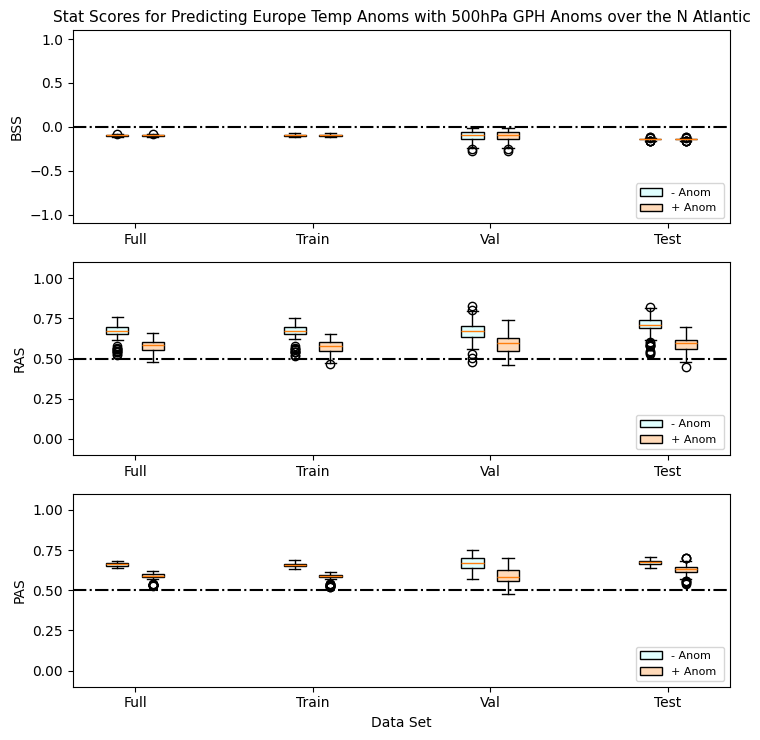

In [25]:
#plot
fig = plt.figure(figsize=(7.5,7.5))
font = 10
#loop through each member
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','peachpuff']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.25 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
ax1.set_title("Stat Scores for Predicting Europe Temp Anoms with 500hPa GPH Anoms over the N Atlantic",fontsize = 11) 

a1_0 = ax1.boxplot([BSS_all[:,0],BSS_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a1_5 = ax1.boxplot([BSS_train[:,0],BSS_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a1_10 = ax1.boxplot([BSS_val[:,0],BSS_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a1_14 = ax1.boxplot([BSS_test[:,0],BSS_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax1.axhline(0, c='k', ls ='-.')
ax1.set_xticks(ind, ticks)
#next few lines color the box plot faces
for bplot in (a1_0, a1_5, a1_10, a1_14,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a1_0['boxes'], labels):
    patch.set_label(label)
#ax1.set_title('BSS for Temperature Region',fontsize = 14)
ax1.set_ylim(-1.1,1.1)
#ax1.set_xlabel('Data Set',fontsize = 14)
ax1.set_ylabel('BSS',fontsize = font)
ax1.tick_params(axis='both', which='major', labelsize= font)
ax1.legend(loc = 'lower right', fontsize = 8)
ax1.set_aspect('auto') ;

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = 8)
ax2.set_aspect('auto') ;

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = 8)
ax3.set_aspect('auto') ;

plt.tight_layout()
#plt.show()
plt.savefig("1203_NAOTemp_StatScore_test.png", bbox_inches='tight',dpi =150)


In [ ]:
#lat
lats = np.arange(80, 29.5, -2.5)
#lon
lons = np.arange(-100, -9.5, 2.5)

In [ ]:
# plot the original data 
color = 'twilight' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
plt.figure(figsize=(7.5,7.5))
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))

h = ax.contourf(lons, lats, np.nanmean(pos90_LRP,axis=0), level,
                transform=ccrs.PlateCarree(), cmap=color,extend='both')
#plt.contourf(lons, lats, LRP_heatmaps_mean, level, cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.07,pad=0.07,aspect=35, label = "Frequency")
cbar.ax.tick_params(labelsize=10) 

#Add in the coordinate system:
long = np.arange(-100, -10, 5)
latg = np.arange(80, 30 ,-2.5)
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=10)
ax.set_yticklabels(latg,fontsize=10)
ax.set_ylabel('Latitude ($^o$N)',fontsize=10);
ax.set_xlabel('Longitude ($^o$W)',fontsize=10);

ax.set_aspect('auto') ;

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')

ax.add_feature(feature1)

plt.tight_layout()
#Set a title for your map:
title = 'Frequency LRP of 500hPa GPH associated with 10% Most Confident + Temp Anomaly Predictions'
plt.title(title,fontsize=11)
plt.savefig("1121_Pos_LRP.png", bbox_inches='tight')

In [ ]:
# plot the original data 
color = 'twilight' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
plt.figure(figsize=(7.5,7.5))
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))

h = ax.contourf(lons, lats, np.nanmean(neg90_LRP,axis=0), level,
                transform=ccrs.PlateCarree(), cmap=color,extend='both')
#plt.contourf(lons, lats, LRP_heatmaps_mean, level, cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.07,pad=0.07,aspect=35, label = "Frequency")
cbar.ax.tick_params(labelsize=10) 

#Add in the coordinate system:
long = np.arange(-100, -10, 5)
latg = np.arange(80, 30 ,-2.5)
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=10)
ax.set_yticklabels(latg,fontsize=10)
ax.set_ylabel('Latitude ($^o$N)',fontsize=10);
ax.set_xlabel('Longitude ($^o$W)',fontsize=10);

ax.set_aspect('auto') ;

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')

ax.add_feature(feature1)

plt.tight_layout()
#Set a title for your map:
title = 'Frequency LRP of 500hPa GPH associated with 10% Most Confident - Temp Anomaly Predictions'
plt.title(title,fontsize=11)
plt.savefig("1121_Neg_LRP.png", bbox_inches='tight')

In [26]:
##pickle out the stuff for making heat maps because I want to run it on a smaller code
##true values
pickle.dump(neg90_LRP, open("neg90_LRP.p", 'wb'))
pickle.dump(pos90_LRP, open("pos90_LRP.p",'wb'))

##false values
pickle.dump(Fneg90_LRP, open("Fneg90_LRP.p",'wb'))
pickle.dump(Fpos90_LRP, open("Fpos90_LRP.p",'wb'))

##for composites
pickle.dump(comp_pos, open("comp_pos.p",'wb'))
pickle.dump(compFpos, open("compFpos.p",'wb'))
pickle.dump(comp_neg, open("comp_neg.p",'wb'))
pickle.dump(compFneg, open("compFneg.p",'wb'))

## Percentile ACC Plots

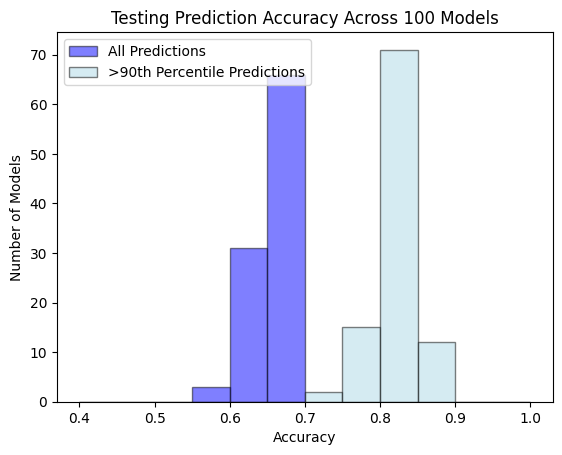

In [27]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Testing Prediction Accuracy Across 100 Models')
plt.savefig("1203_ACCtest.png", dpi = 150)
plt.show()

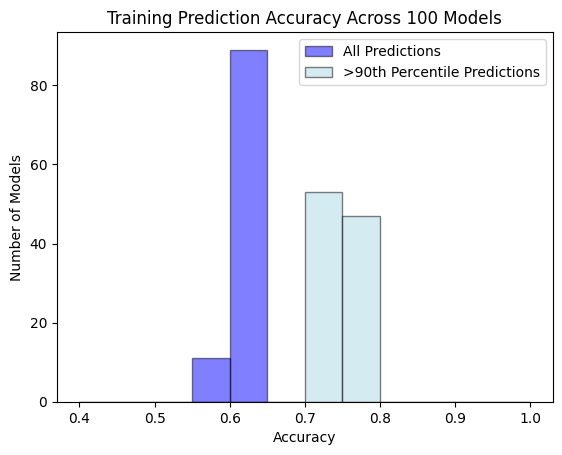

In [28]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(train90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltrain_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Training Prediction Accuracy Across 100 Models')
plt.savefig("1203_ACCtrain.png", dpi = 150)
plt.show()

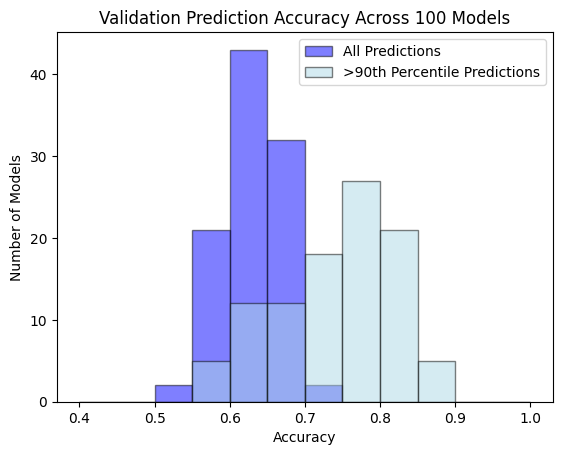

In [29]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(val90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fullval_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Validation Prediction Accuracy Across 100 Models')
plt.savefig("1203_ACCval.png", dpi = 150)
plt.show()